# **Libraries**

In [ ]:
install.packages("keras")
install.packages("tidyverse")
install.packages("dplyr")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘data.table’, ‘gargle’, ‘ids’, ‘dbplyr’, ‘dtplyr’, ‘googledrive’, ‘googlesheets4’, ‘pillar’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’




In [ ]:
library(keras)
library(dplyr)
library(caret)
#library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: ggplot2

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# **Used functions**

In [ ]:

## Used functions
target_transform <- function(y){
  name = sort(unique(y))
  
  l = length(name)
  n = length(y)
  
  target = matrix(0, nrow = n, ncol = l)
  for (i in 1:l){
    target[y==name[i], i] = 1
  }
  colnames(target) <- name
  return(target)
}

fit_target <- function(y, n_y){
  n = length(y)
  target = matrix(0, n, n_y)
  for (i in 1:n_y){
    target[y==i, i] = 1
  }
  return(target)
}

sigm <- function(x){
  return(1/(1+exp(-x)))
}

softplus <- function(x){
  M = log(1+exp(x))
  is_inf = (M==Inf)
  M[M==Inf] = 0
  return(M + x*is_inf)
}

mini_batch <- function(n, batch.size){
  id = vector(mode = 'list')
  l = ceiling(n/batch.size)
  if (l==1){
    id[[1]] = 1:n
  }
  else{
    x = sample(1:n)
    for (i in 1:(l-1)){
      id[[i]] = x[((i-1) * batch.size + 1) : (i * batch.size )]
    }
    id[[l]] = x[((l-1) * batch.size + 1) : n]
  }
  return(id)
}

generative_gradient <- function(x0, y0, W, U, b, c, d, alpha = 0){
  n_b = dim(x0)[1]
  n_y = dim(y0)[2]
  n.hidden = length(c)
  h0 = t(sigm(W %*% t(x0) + U%*%t(y0)+ c))
  h0_s = (h0 > matrix(runif(n.hidden * n_b), n_b, n.hidden)) * 1
  
  p_y_h = t(apply(d + h0_s %*% U, 1, function(x) x-max(x)))
  p_y_h = t(apply(exp(p_y_h), 1, function(x) x/sum(x)))
  #p_y_h_c = t(apply(p_y_h, 1, cumsum))
  y1 = t(apply(p_y_h, 1, function(x) fit_target(sample(1:10,1,prob = x), n_y)))
  #y1 = rowSums(p_y_h_c < runif(n_b)) + 1
  #y1 = fit_target(y1, n_y)
  #y1 = p_y_h
  p_x_h = sigm(b + h0_s %*% W)
  #x1 = (p_x_h > matrix(runif(n_x * n), n_b, n_x)) * 1 
  x1 = p_x_h
  h1 = t(sigm(W%*%t(x1) + U%*%t(y1)+ c))
  
  grad_W = -(t(h0)%*%x0 - t(h1)%*%x1) / n_b
  grad_U = -(t(h0)%*%y0 - t(h1)%*%y1) / n_b
  grad_b = -colMeans(x0 - x1)
  grad_d = -colMeans(y0 - y1)
  grad_c = -colMeans(h0 - h1)
  
  return(list(grad_W = grad_W,
              grad_U = grad_U,
              grad_b = grad_b,
              grad_c = grad_c,
              grad_d = grad_d))
}

discriminative_gradient <- function(x0, y0, W, U, b, c, d, alpha = 0){
  n_b = dim(x0)[1]
  n_y = dim(y0)[2]
  n.hidden = length(c)
  theta = W%*%t(x0)+ c
  
  h0 = t(sigm(theta + U%*%t(y0)))
  
  exp_free_energy = matrix(0,n_b,n_y)
  for (m in 1:n_y){
    y_s = matrix(0,n_b,n_y)
    y_s[,m]= 1
    exp_free_energy[,m] = d[m] + rowSums(softplus(t(theta + U%*%t(y_s))))
  }
  exp_free_energy = t(apply(exp_free_energy, 1, function(x) x-max(x)))
  p_y_x = t(apply(exp(exp_free_energy), 1, function(x) x/sum(x)))
  
  second_term_c = matrix(0,n.hidden,n_y)
  second_term_WU = matrix(0,n_b,n.hidden)
  
  for (m in 1:n_y){
    y_s = matrix(0,n_b,n_y)
    y_s[,m]= 1
    h_yx = t(sigm(theta + U%*%t(y_s)))
    sc = h_yx * p_y_x[,m]
    second_term_c[,m] = colSums(sc)
    second_term_WU = second_term_WU + sc
  }
  
  grad_c = -(colSums(h0) - rowSums(second_term_c)) / n_b
  grad_W = -t(h0 - second_term_WU)%*%x0 / n_b
  grad_U = -t(h0 - second_term_WU)%*%y0 / n_b
  grad_d = -colMeans(y0 - p_y_x)
  
  return(list(grad_W = grad_W,
              grad_U = grad_U,
              grad_b = rep(0, length(b)),
              grad_c = grad_c,
              grad_d = grad_d))
}

hybrid_gradient <- function(x0, y0, W, U, b, c, d, alpha = 0.01){
  grad_discriminative = discriminative_gradient(x0, y0, W, U, b, c, d)
  grad_generative = generative_gradient(x0, y0, W, U, b, c, d)
  
  grad_W = grad_discriminative$grad_W + alpha * grad_generative$grad_W
  grad_U = grad_discriminative$grad_U + alpha * grad_generative$grad_U
  grad_b = grad_discriminative$grad_b + alpha * grad_generative$grad_b
  grad_d = grad_discriminative$grad_d + alpha * grad_generative$grad_d
  grad_c = grad_discriminative$grad_c + alpha * grad_generative$grad_c

  return(list(grad_W = grad_W,
              grad_U = grad_U,
              grad_b = grad_b,
              grad_c = grad_c,
              grad_d = grad_d))
}

predictRBM <- function(x, y, paras){ 
  n.hidden = length(paras$c)
  h = rep(0, n.hidden)
  W = paras$W
  U = paras$U
  b = paras$b
  c = paras$c
  d = paras$d
  n_y = length(d)
  
  if (is.null(dim(x))){
    x = matrix(x, nrow = 1)
    y = matrix(y, nrow = 1)
  }
  
  theta = W%*%t(x)+ c
  exp_free_energy = matrix(0,dim(x)[1],n_y)
  for (m in 1:n_y){
    y_s = matrix(0,dim(x)[1],n_y)
    y_s[,m]= 1
    exp_free_energy[,m] = d[m] + rowSums(softplus(t(theta + U%*%t(y_s))))
  }
  exp_free_energy = t(apply(exp_free_energy, 1, function(x) x-max(x)))
  p_y_x = t(apply(exp(exp_free_energy), 1, function(x) x/sum(x)))
  pred = apply(p_y_x, 1, function(x) which.max(x))
  class_pred = fit_target(pred, n_y)
  if (missing(y)){
    return(list(prob=p_y_x, class=class_pred))
  }
  else{
    train = apply(y, 1, function(x) which.max(x))
    pred = apply(p_y_x, 1, function(x) which.max(x))
    return(list(prob=p_y_x, class=class_pred, accuracy=sum(train==pred)))
  }
}

reconstructionRBM <- function(x, y , paras){
  n.hidden = length(paras$c)
  h = rep(0, n.hidden)
  W = paras$W
  U = paras$U
  b = paras$b
  c = paras$c
  d = paras$d
  
  if (is.null(dim(x))){
    x = matrix(x, nrow = 1)
    y = matrix(y, nrow = 1)
  }
  
  n_b = dim(x)[1]
  n_y = dim(y)[2]
  h0 = t(sigm(W%*%t(x) + U%*%t(y)+ c))
  h0_s = (h0 > matrix(runif(n.hidden * n_b), n_b, n.hidden)) * 1
  p_x_h = sigm(b + h0_s %*% W)
  return(p_x_h)
}


RBM_training <- function(x, y, paras, 
                         n.hidden = 100, 
                         x_val, y_val, 
                         type = 'hybrid', #3 types: generative, discriminative and hybrid
                         alpha = 0.01, #for hybrid training
                         lr = 0.01,
                         n.epoch = 100,
                         batch.size = 100, 
                         opt = 'Adam', #3 types of optimizer: GD (gradient descent), Momentum and Adam
                         mu = 0.9, #for Momentum
                         beta1 = 0.9, #for Adam
                         beta2 = 0.999, #for Adam
                         eps = 1e-8, #for Adam
                         sample_rec = 27, #sample observation for inspecting reconstruction during Generative training
                         image.size = c(28,28) #size of image
                         ){
  n = dim(x)[1]
  n_x = dim(x)[2]
  n_y = dim(y)[2]
  
  if (missing(paras)){
    h = rep(0, n.hidden)
    W = matrix(runif(n.hidden * n_x), nrow = n.hidden, ncol = n_x) / 100 - 0.5/100
    U = matrix(runif(n.hidden * n_y), nrow = n.hidden, ncol = n_y) / 100 - 0.5/100
    b = runif(n_x) / 100 - 0.5/100
    d = runif(n_y) / 100 - 0.5/100
    c = runif(n.hidden) / 100 - 0.5/100
  }
  else{
    n.hidden = length(paras$c)
    h = rep(0, n.hidden)
    W = paras$W
    U = paras$U
    b = paras$b
    c = paras$c
    d = paras$d
    }
  gradient = get(paste(type, 'gradient', sep="_", collapse = NULL))
  # initial values for optimizer
  m_W <- m_U <- m_b <- m_c <- m_d <-0
  v_W <- v_U <- v_b <- v_c <- v_d <-0
  u_W <- u_U <- u_b <- u_c <- u_d <-0
  
  train_acc = vector(mode='numeric')
  val_acc = vector(mode='numeric')
  
  reconstruction_sample = NULL
  #Reconstruction sample for Generative traning
  if (type == 'generative'){
    current_rec = reconstructionRBM(x[sample_rec,], y[sample_rec,], 
                                    list(W = W, U = U, b = b, c = c, d = d))
    options(repr.plot.width=12, repr.plot.height=6)
    par(mfrow=c(1,2))
    image(matrix(x[sample_rec,], nrow = image.size[1]), ylim=c(1,0))
    image(matrix(current_rec, nrow = image.size[1]), ylim=c(1,0))
    reconstruction_sample = current_rec
  }
  
  for (i in 1:n.epoch){
    id <- mini_batch(n, batch.size)
    for (k in 1:length(id)){
      x0 = x[id[[k]],]
      y0 = y[id[[k]],]
      if (batch.size == 1){
        x0 = matrix(x0, nrow = 1)
        y0 = matrix(y0, nrow = 1)
      }
      # Update parameters
      grad = gradient(x0, y0, W, U, b, c, d, alpha)
      
      if (opt == 'Adam'){
        m_W = beta1*m_W + (1-beta1)*grad$grad_W
        mt_W = m_W / (1-beta1^i)
        v_W = beta2*v_W + (1-beta2)*(grad$grad_W^2)
        vt_W = v_W / (1-beta2^i)
        u_W = -lr * mt_W / (sqrt(vt_W) + eps)
        
        m_U = beta1*m_U + (1-beta1)*grad$grad_U
        mt_U = m_U / (1-beta1^i)
        v_U = beta2*v_U + (1-beta2)*(grad$grad_U^2)
        vt_U = v_U / (1-beta2^i)
        u_U = -lr * mt_U / (sqrt(vt_U) + eps)
        
        m_b = beta1*m_b + (1-beta1)*grad$grad_b
        mt_b = m_b / (1-beta1^i)
        v_b = beta2*v_b + (1-beta2)*(grad$grad_b^2)
        vt_b = v_b / (1-beta2^i)
        u_b = -lr * mt_b / (sqrt(vt_b) + eps)
        
        m_c = beta1*m_c + (1-beta1)*grad$grad_c
        mt_c = m_c / (1-beta1^i)
        v_c = beta2*v_c + (1-beta2)*(grad$grad_c^2)
        vt_c = v_c / (1-beta2^i)
        u_c = -lr * mt_c / (sqrt(vt_c) + eps)
        
        m_d = beta1*m_d + (1-beta1)*grad$grad_d
        mt_d = m_d / (1-beta1^i)
        v_d = beta2*v_d + (1-beta2)*(grad$grad_d^2)
        vt_d = v_d / (1-beta2^i)
        u_d = -lr * mt_d / (sqrt(vt_d) + eps)
        
      }
      
      else if (opt == 'GD'){
        u_W = - lr * grad$grad_W
        u_U = - lr * grad$grad_U
        u_b = - lr * grad$grad_b
        u_d = - lr * grad$grad_d
        u_c = - lr * grad$grad_c
      }
      
      
      else if (opt == 'Momentum'){
        u_W = mu * u_W - lr * grad$grad_W
        u_U = mu * u_U - lr * grad$grad_U
        u_b = mu * u_b - lr * grad$grad_b
        u_d = mu * u_d - lr * grad$grad_d
        u_c = mu * u_c - lr * grad$grad_c
      }
      
      W = W + u_W
      U = U + u_U
      b = b + u_b
      c = c + u_c
      d = d + u_d
      
    }
    print(paste('Epoch', i, sep = " "))
    #Training accuracy
    pred = predictRBM(x, y, list(W = W, U = U, b = b, c = c, d = d))
    train_acc = append(train_acc, pred$accuracy/n)
    print(paste('Training accuracy:', tail(train_acc,1)))
    
    #Validation acurracy
    if(!missing(x_val)){
      pred = predictRBM(x_val, y_val, list(W = W, U = U, b = b, c = c, d = d))
      val_acc = append(val_acc, pred$accuracy/dim(x_val)[1])
      print(paste('Validation accuracy:', tail(val_acc,1)))
    }
    
    #Reconstruction sample for Generative traning
    if (type == 'generative'){
      current_rec = reconstructionRBM(x[sample_rec,], y[sample_rec,], 
                                      list(W = W, U = U, b = b, c = c, d = d))
      options(repr.plot.width=12, repr.plot.height=6)
      par(mfrow=c(1,2))
      image(matrix(x[sample_rec,], nrow = 28), ylim=c(1,0))
      image(matrix(current_rec, nrow = 28), ylim=c(1,0))
      reconstruction_sample = rbind(reconstruction_sample, current_rec)
    }
  }
  paras = list(W = W, U = U, b = b, c = c, d = d)
  return(list(paras = paras,
              train_acc = train_acc,
              val_acc = val_acc,
              reconstruction_sample = reconstruction_sample))
}



# **Load Data**

In [ ]:
# Training with 50.000 observation:
mnist <- dataset_mnist()
img_rows <- 28
img_cols <- 28

x <- (mnist$train$x/255) %>% array_reshape(c(nrow(mnist$train$x), img_rows * img_cols)) 
x_test <- (mnist$test$x/255) %>% array_reshape(c(nrow(mnist$test$x), img_rows * img_cols)) 

#y_train <- target_transform(mnist$train$y)
y_test <- target_transform(mnist$test$y)

y <- mnist$train$y

cvIndex <- createFolds(y, 6, returnTrain = F)

x_val <- x[cvIndex[[1]],]
y_val <- y[cvIndex[[1]]]
y_val = target_transform(y_val)

x_train <- x[-cvIndex[[1]],]
y_train <- y[-cvIndex[[1]]]
y_train = target_transform(y_train)



# **Generative**

[1] "Epoch 1"
[1] "Training accuracy: 0.90674"
[1] "Validation accuracy: 0.9058"


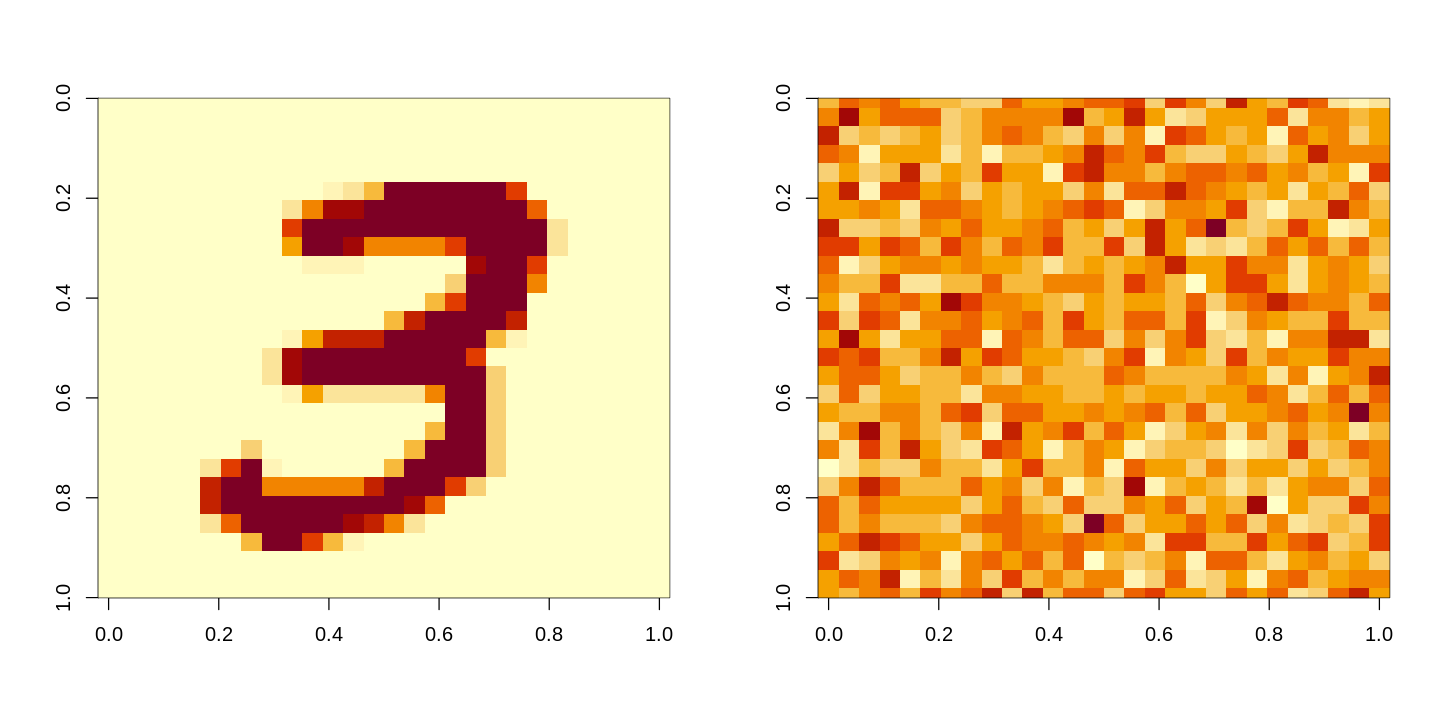

[1] "Epoch 2"
[1] "Training accuracy: 0.92134"
[1] "Validation accuracy: 0.9173"


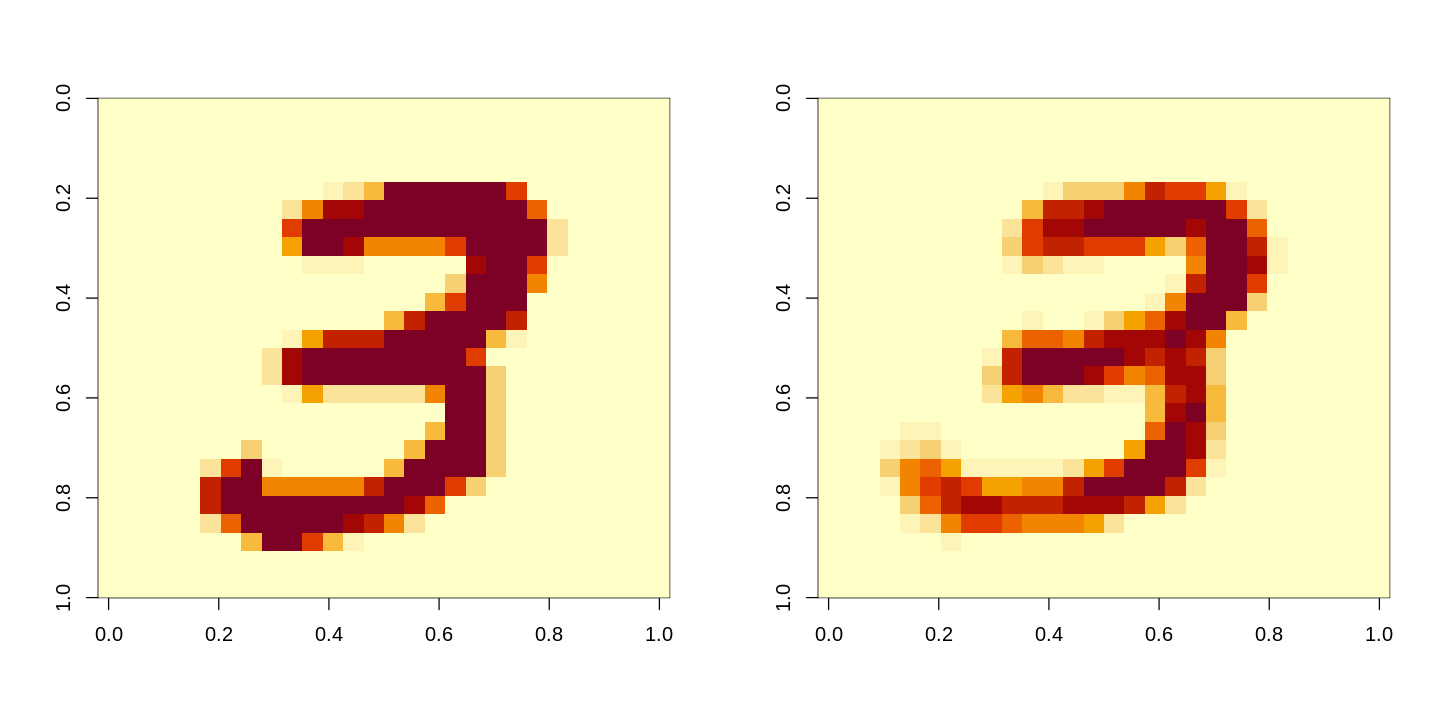

[1] "Epoch 3"
[1] "Training accuracy: 0.92864"
[1] "Validation accuracy: 0.923"


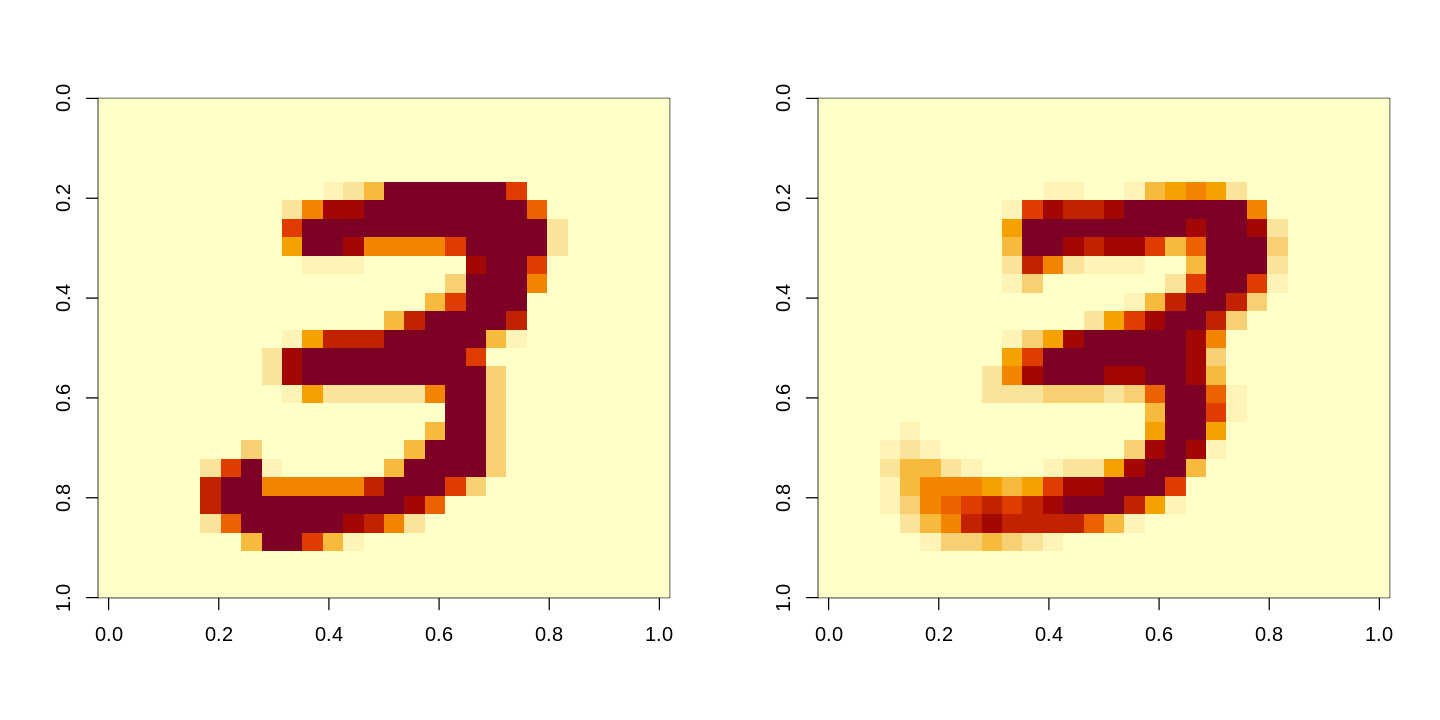

[1] "Epoch 4"
[1] "Training accuracy: 0.93258"
[1] "Validation accuracy: 0.9295"


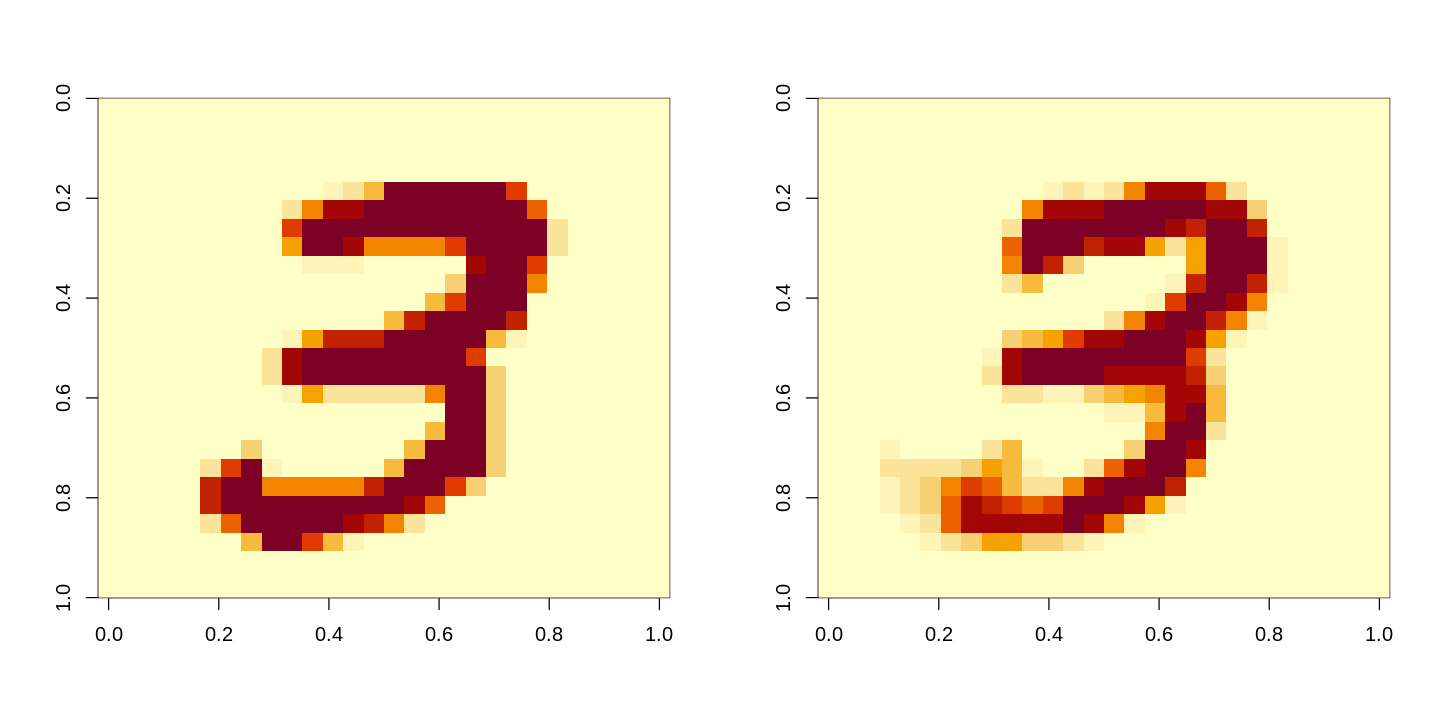

[1] "Epoch 5"
[1] "Training accuracy: 0.93492"
[1] "Validation accuracy: 0.9294"


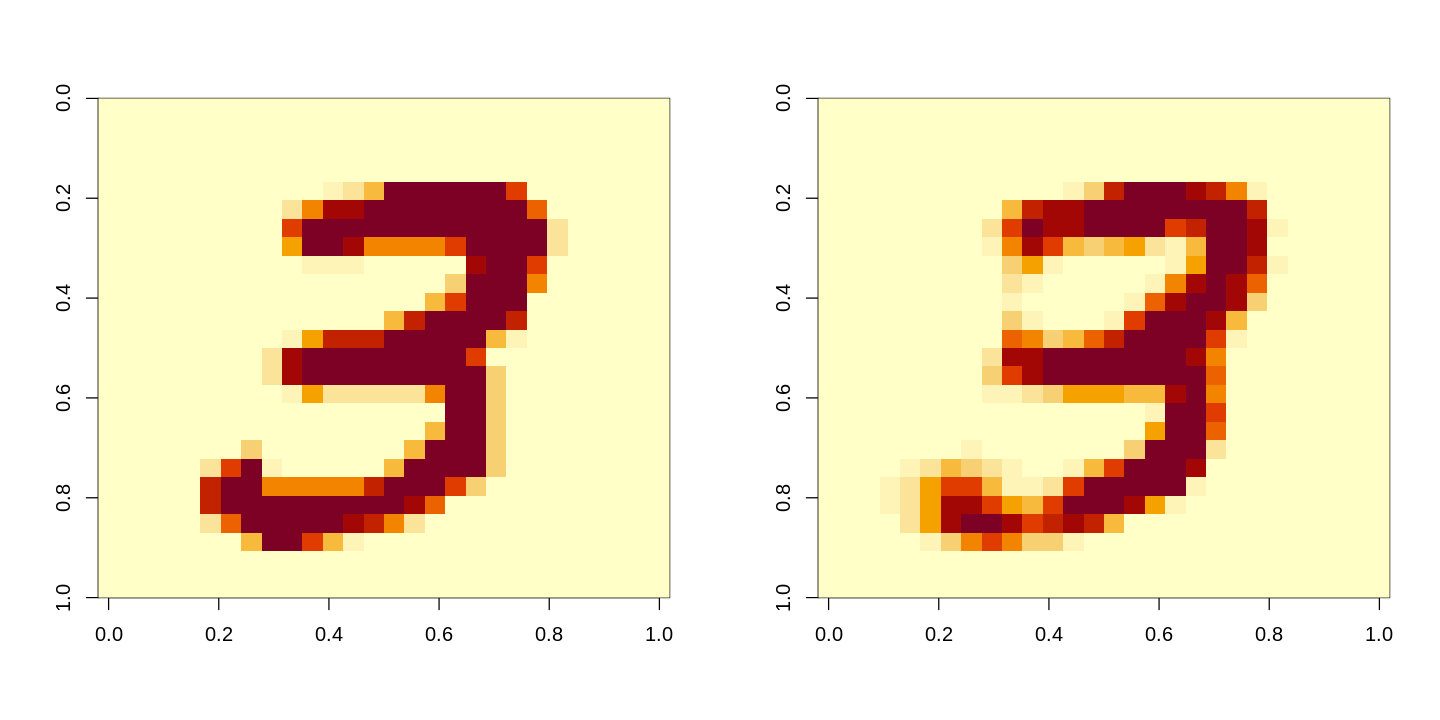

[1] "Epoch 6"
[1] "Training accuracy: 0.93636"
[1] "Validation accuracy: 0.9308"


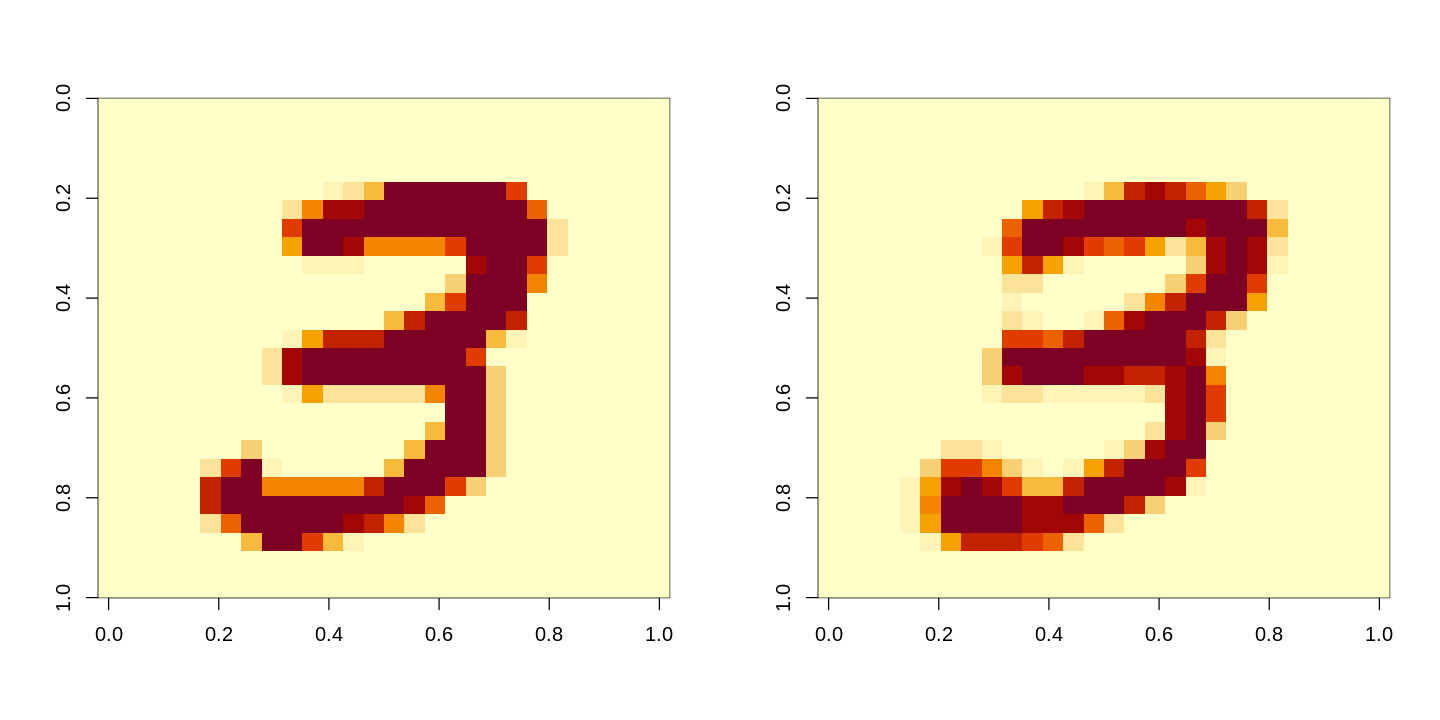

[1] "Epoch 7"
[1] "Training accuracy: 0.93602"
[1] "Validation accuracy: 0.9281"


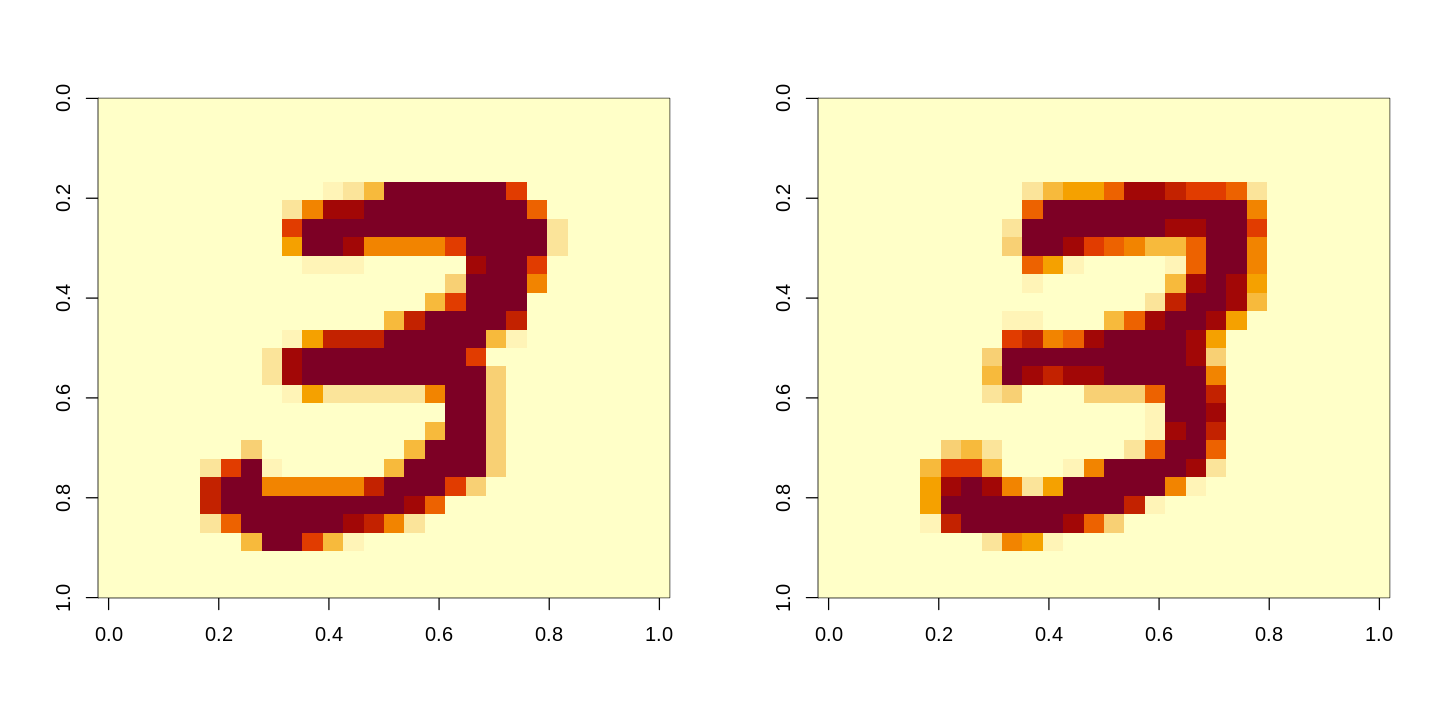

[1] "Epoch 8"
[1] "Training accuracy: 0.93602"
[1] "Validation accuracy: 0.9324"


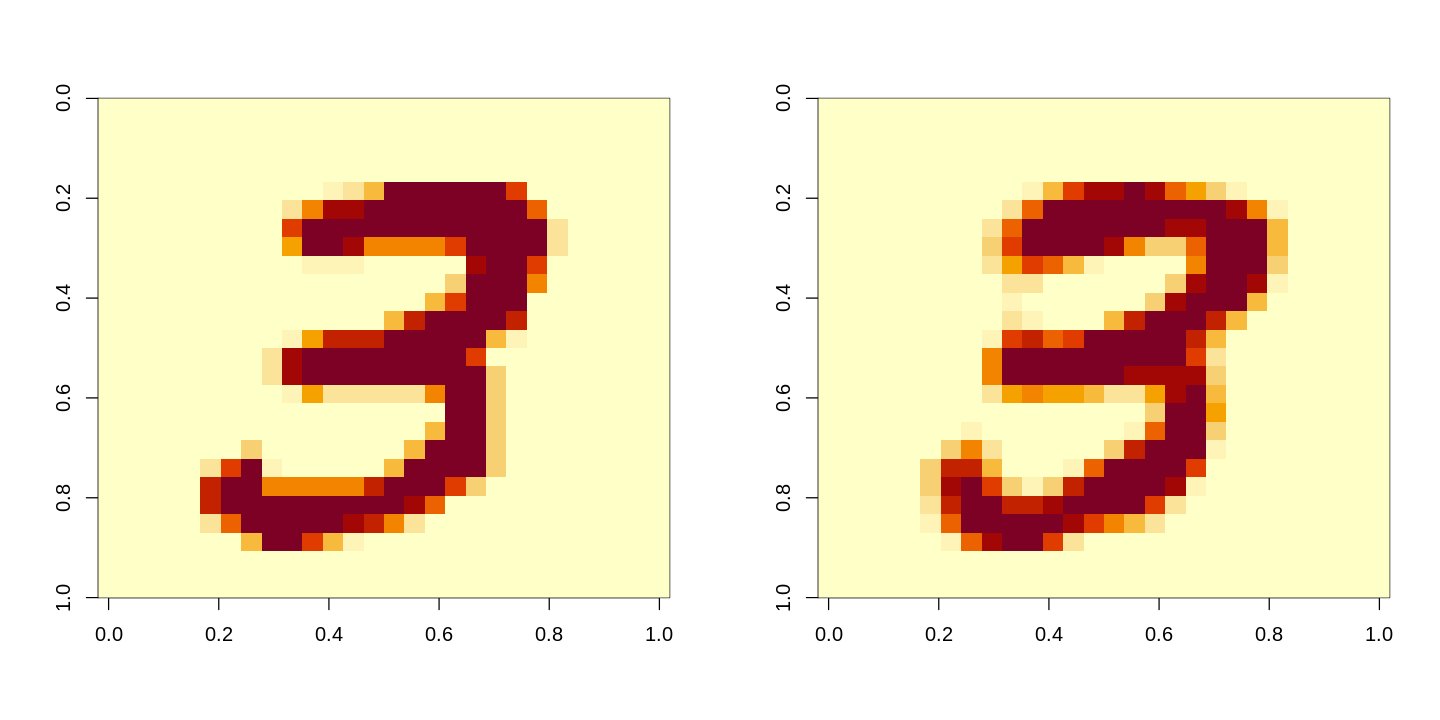

[1] "Epoch 9"
[1] "Training accuracy: 0.9383"
[1] "Validation accuracy: 0.9326"


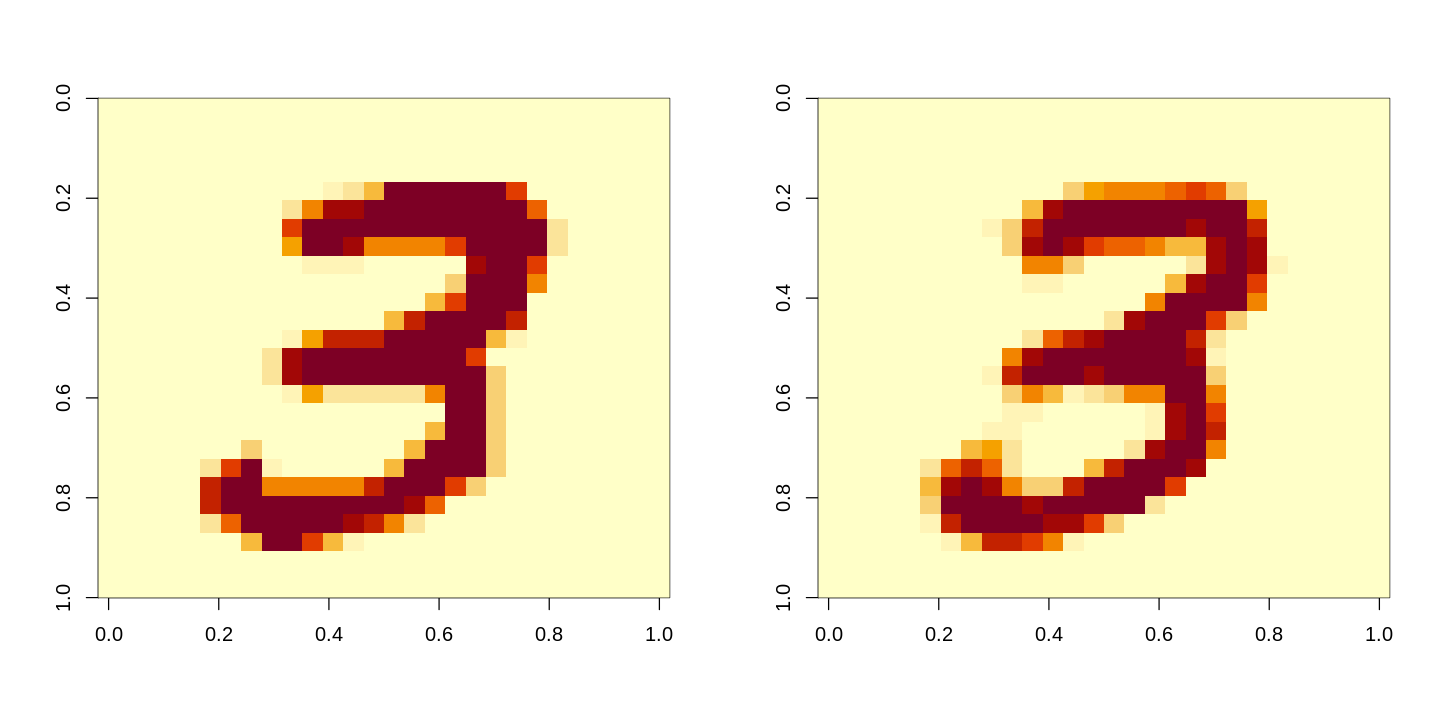

[1] "Epoch 10"
[1] "Training accuracy: 0.93656"
[1] "Validation accuracy: 0.9319"


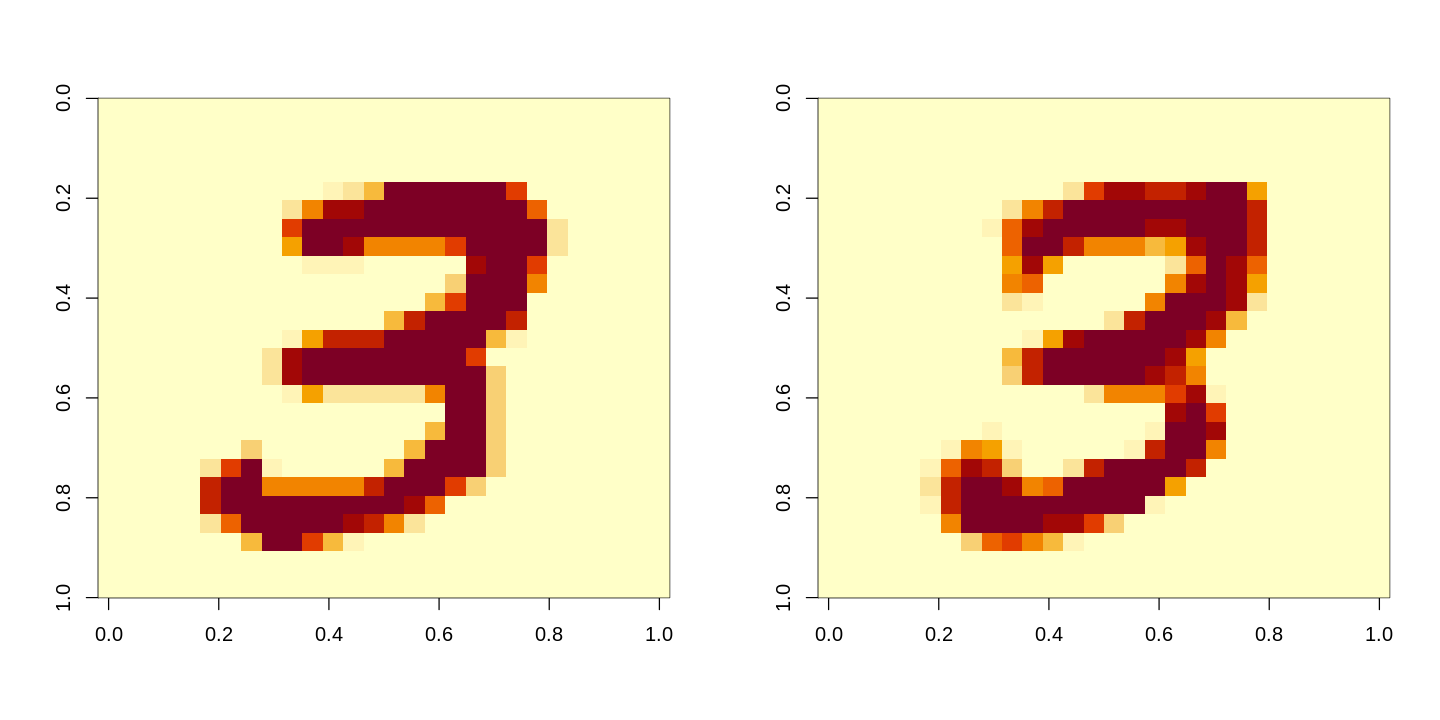

[1] "Epoch 11"
[1] "Training accuracy: 0.93786"
[1] "Validation accuracy: 0.9329"


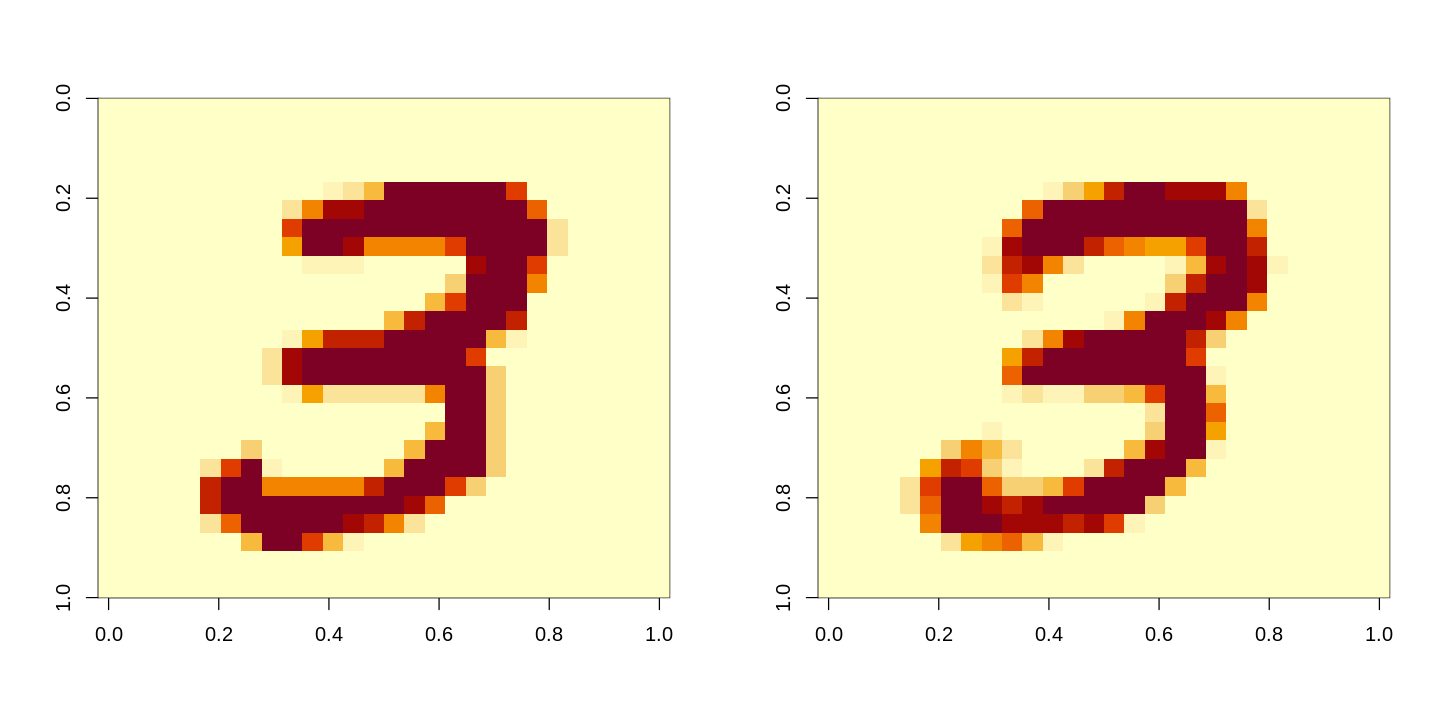

[1] "Epoch 12"
[1] "Training accuracy: 0.93922"
[1] "Validation accuracy: 0.9343"


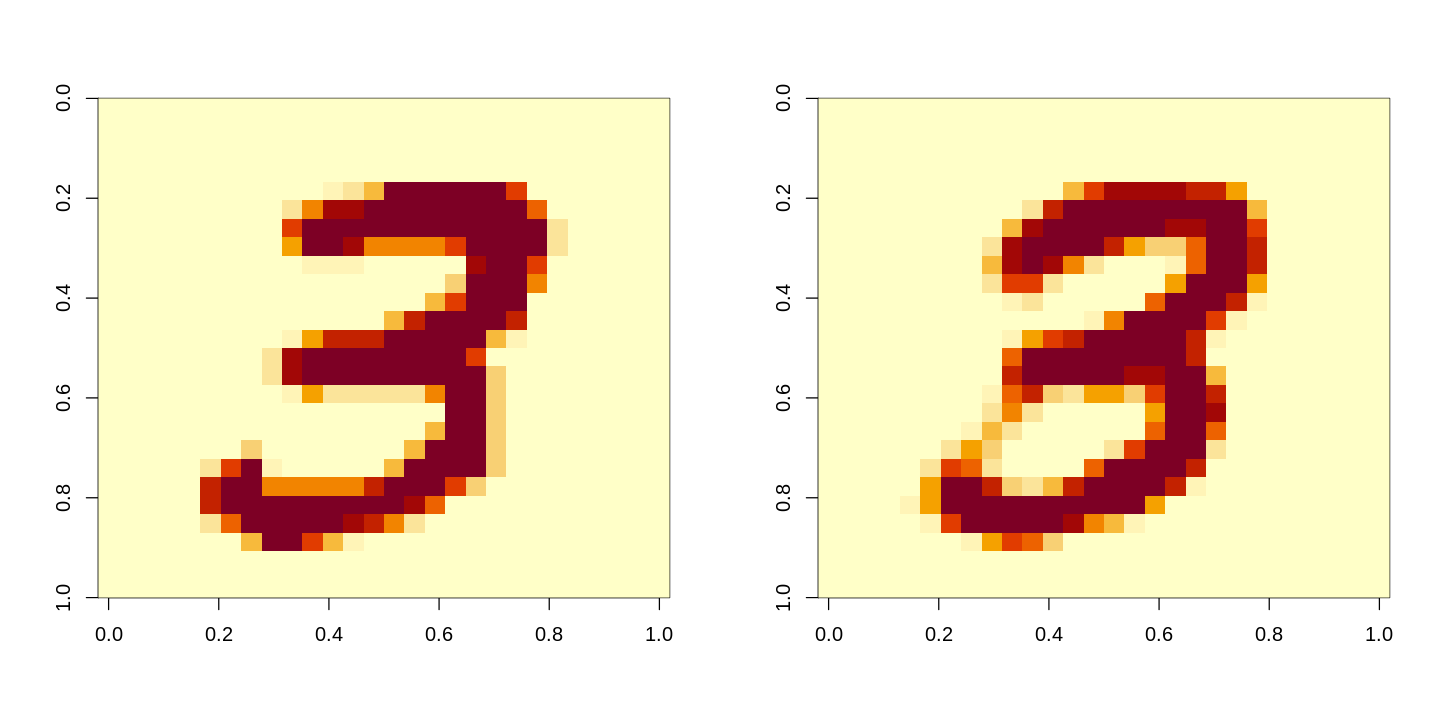

[1] "Epoch 13"
[1] "Training accuracy: 0.93862"
[1] "Validation accuracy: 0.9328"


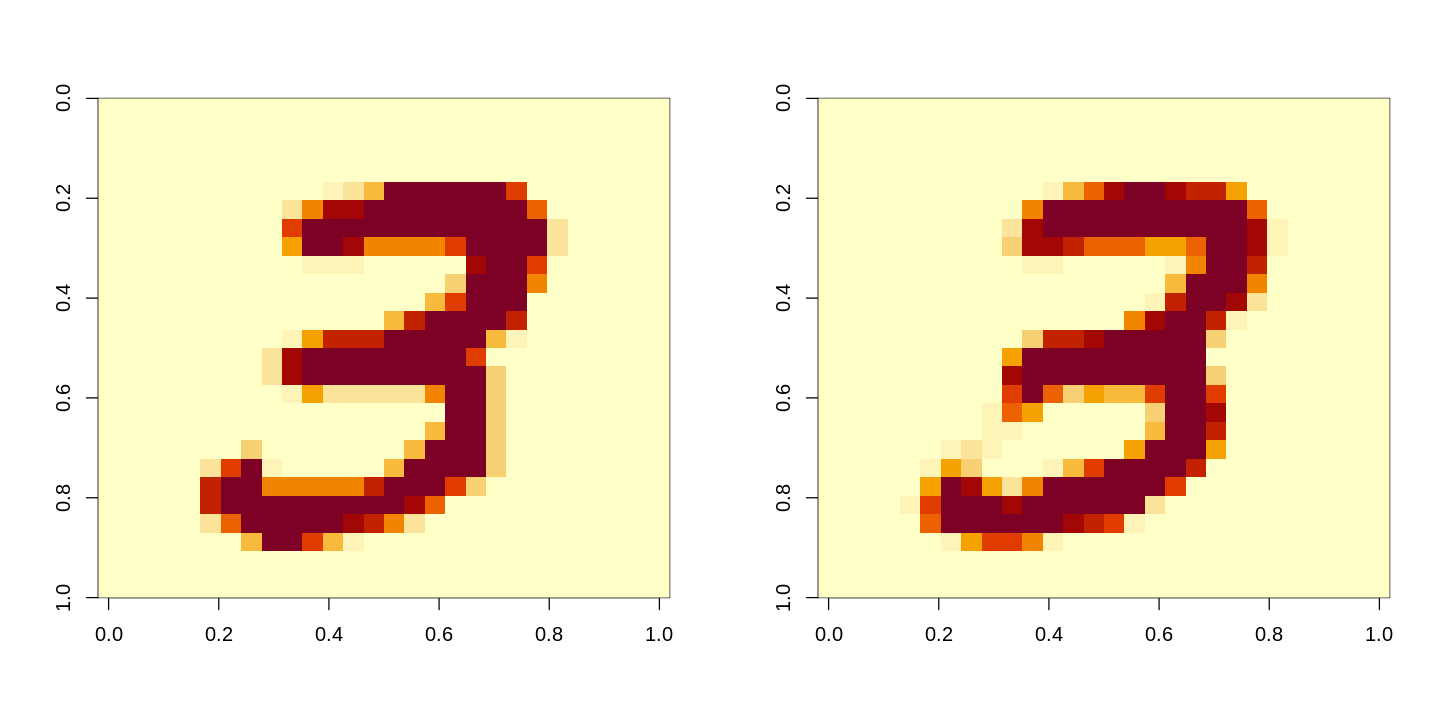

[1] "Epoch 14"
[1] "Training accuracy: 0.9402"
[1] "Validation accuracy: 0.9337"


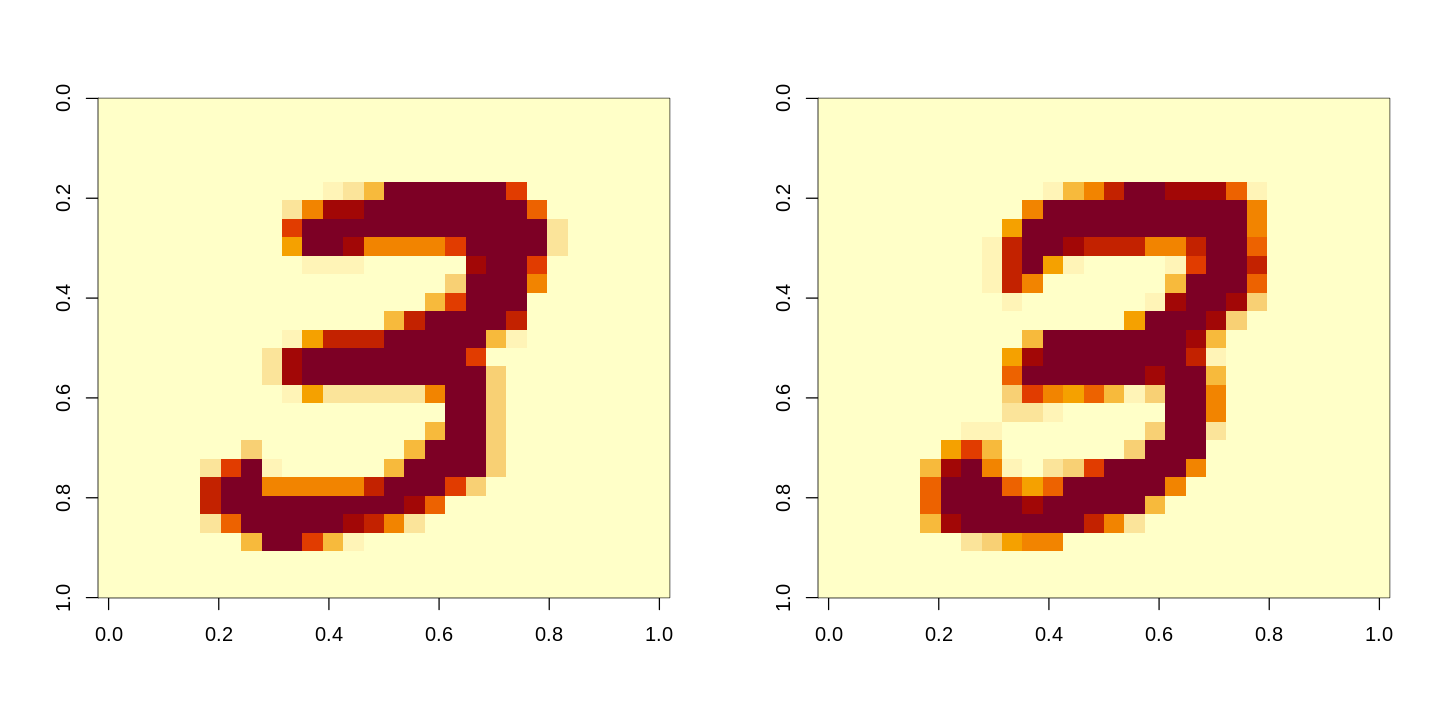

[1] "Epoch 15"
[1] "Training accuracy: 0.9378"
[1] "Validation accuracy: 0.9297"


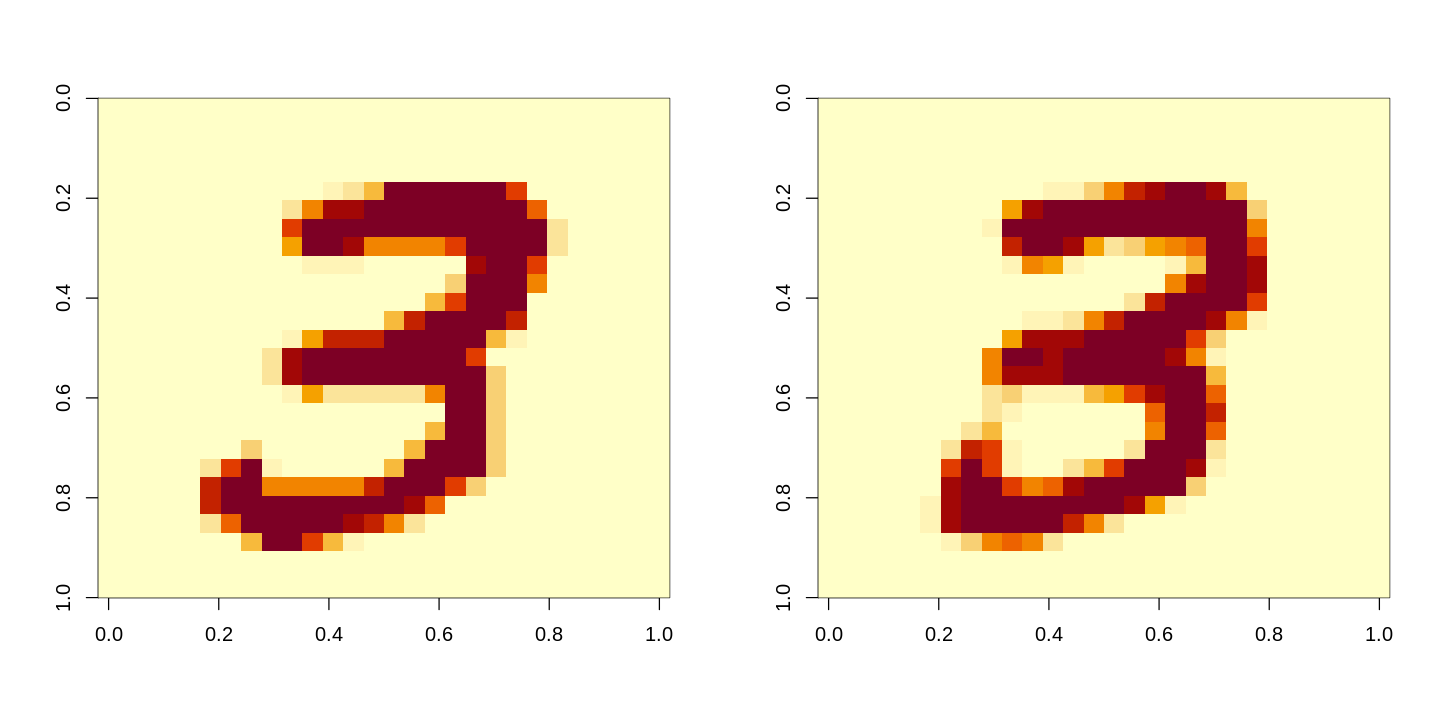

[1] "Epoch 16"
[1] "Training accuracy: 0.93868"
[1] "Validation accuracy: 0.9331"


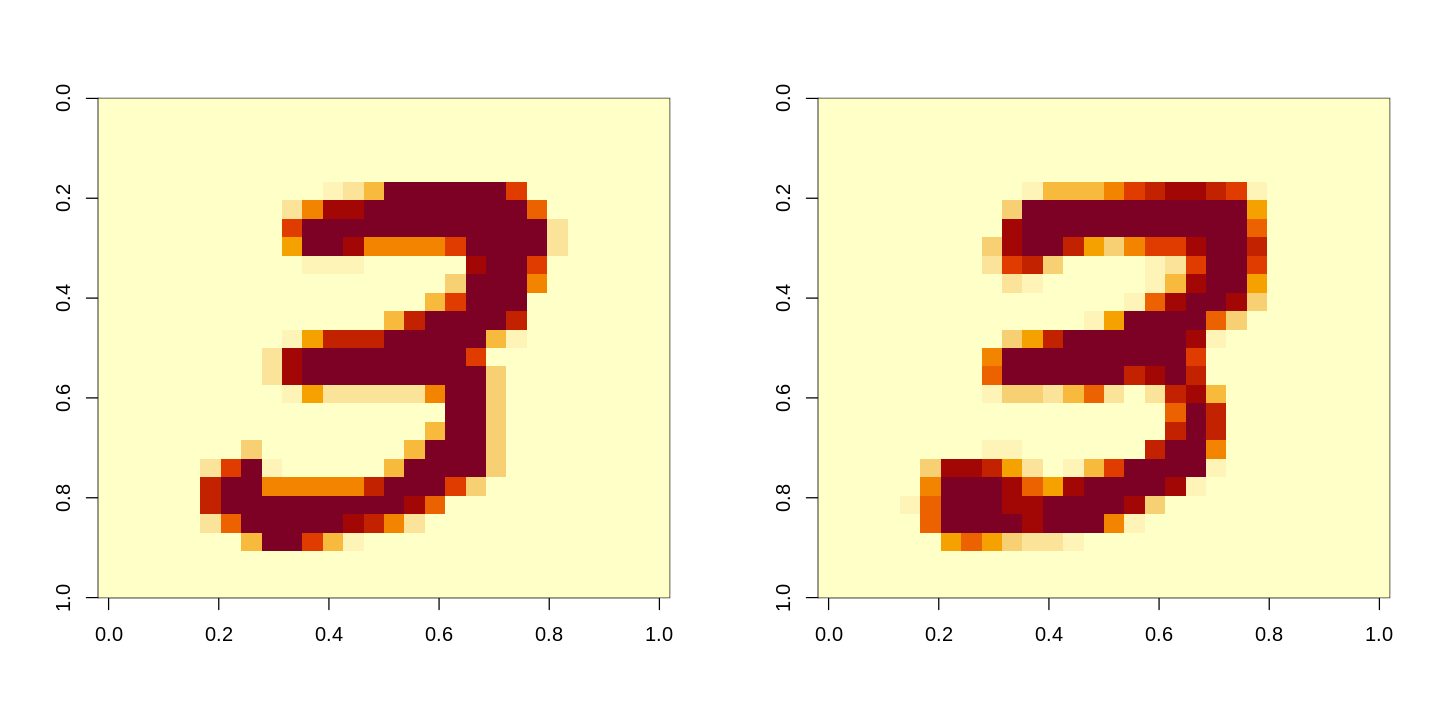

[1] "Epoch 17"
[1] "Training accuracy: 0.93906"
[1] "Validation accuracy: 0.9304"


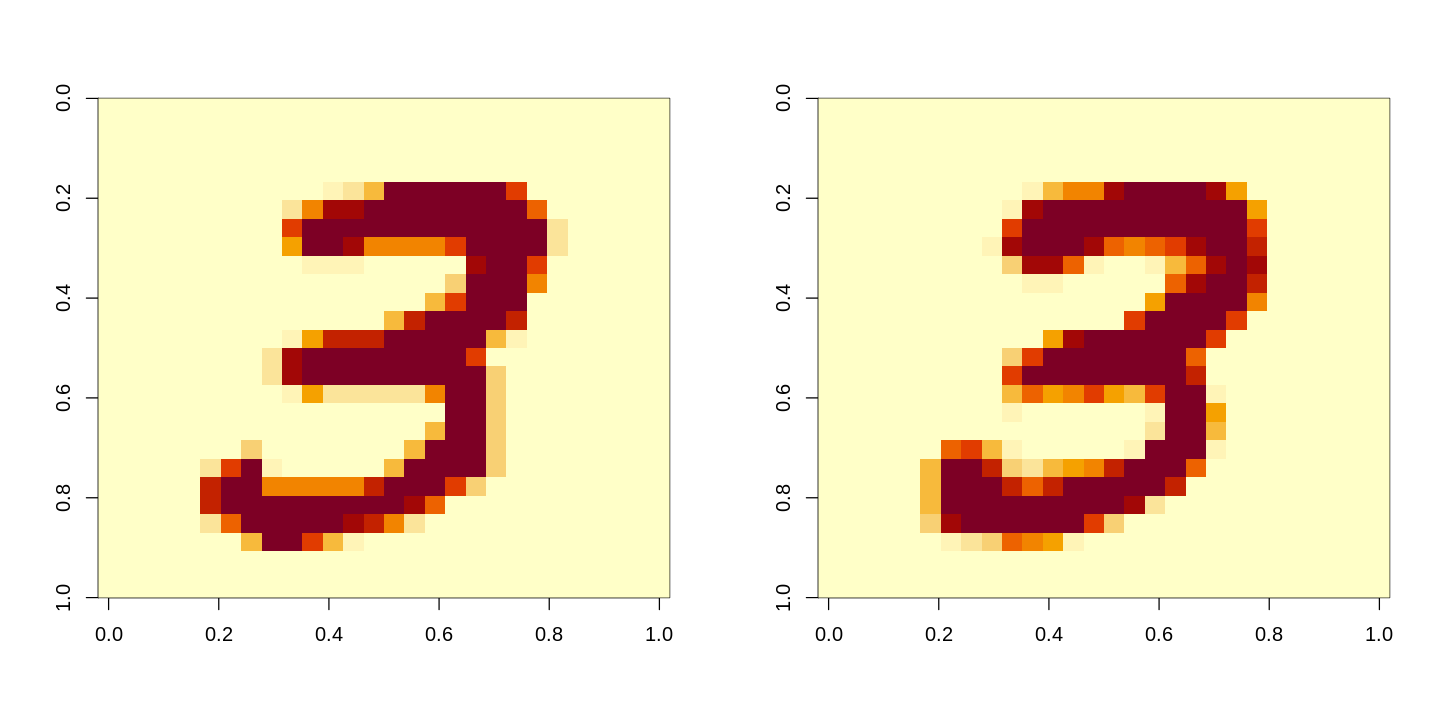

[1] "Epoch 18"
[1] "Training accuracy: 0.93974"
[1] "Validation accuracy: 0.9335"


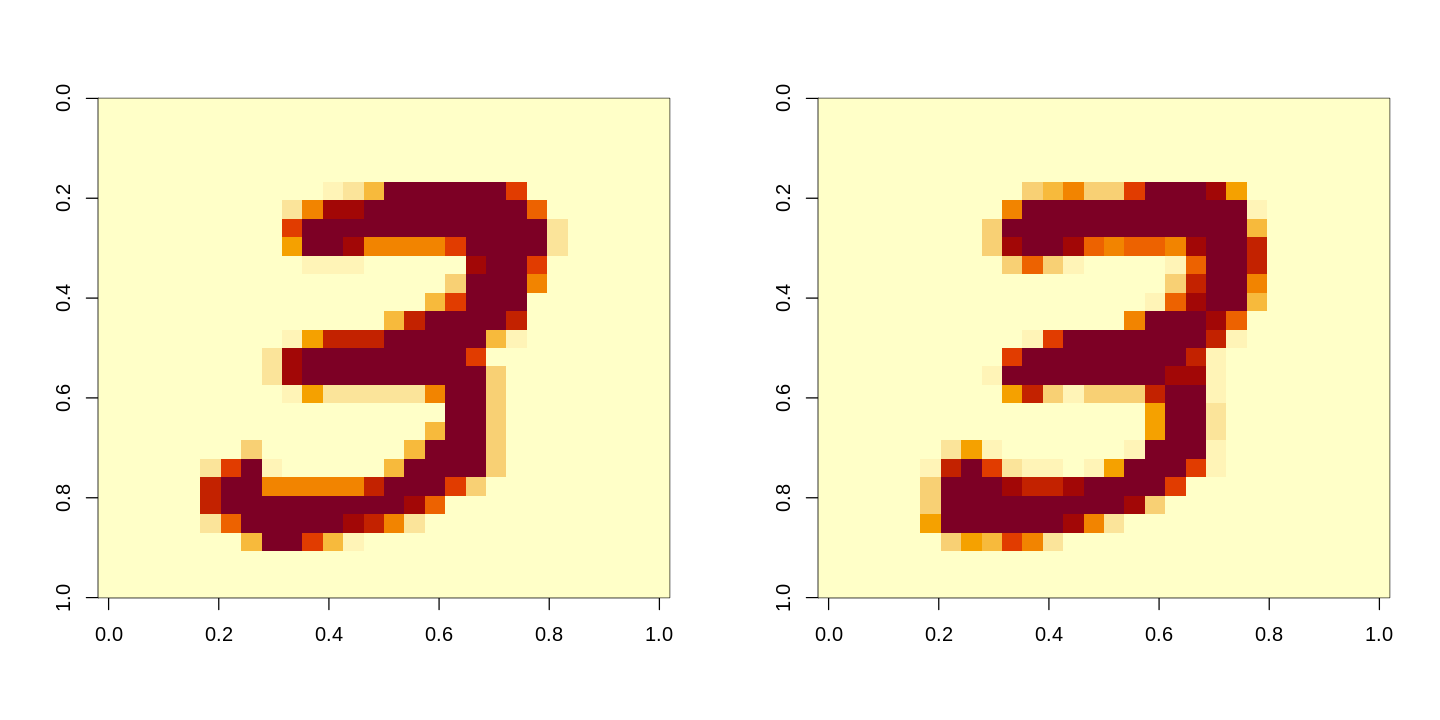

[1] "Epoch 19"
[1] "Training accuracy: 0.9355"
[1] "Validation accuracy: 0.9273"


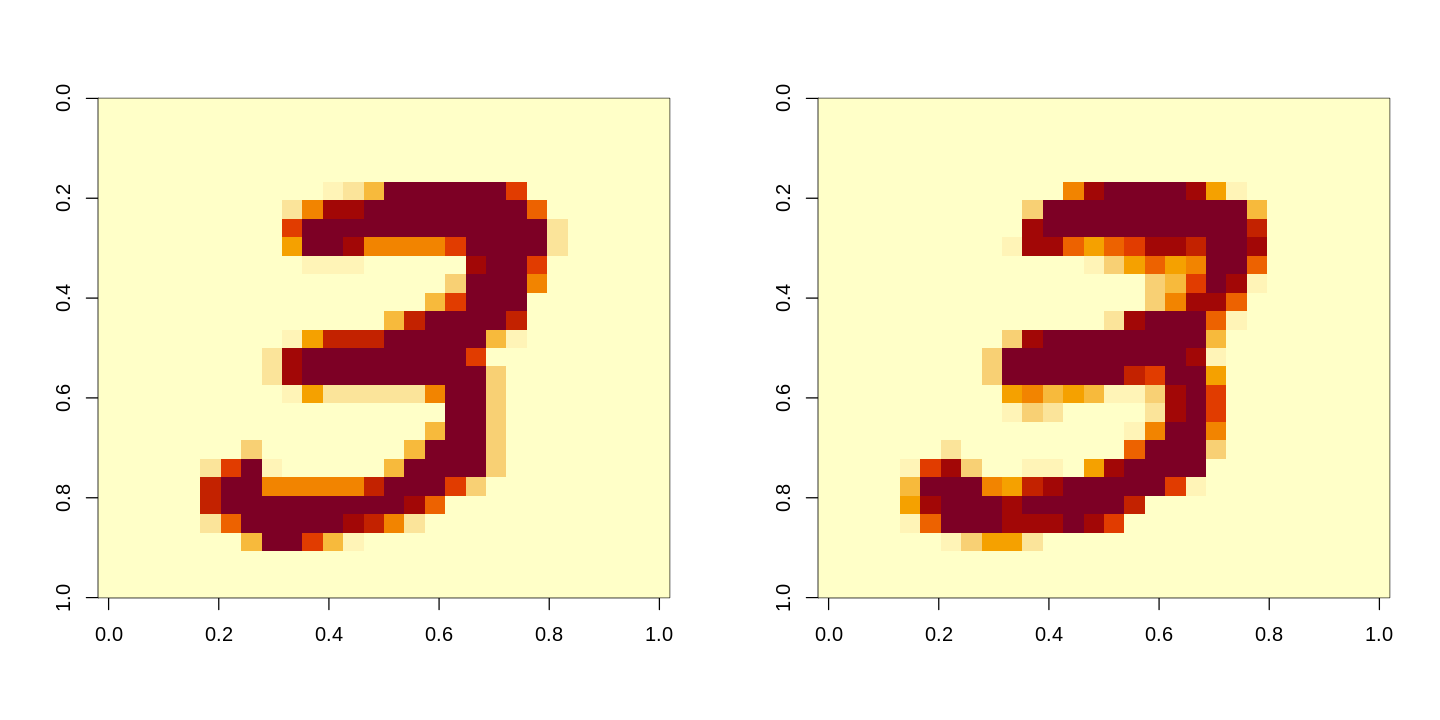

[1] "Epoch 20"
[1] "Training accuracy: 0.93888"
[1] "Validation accuracy: 0.9319"


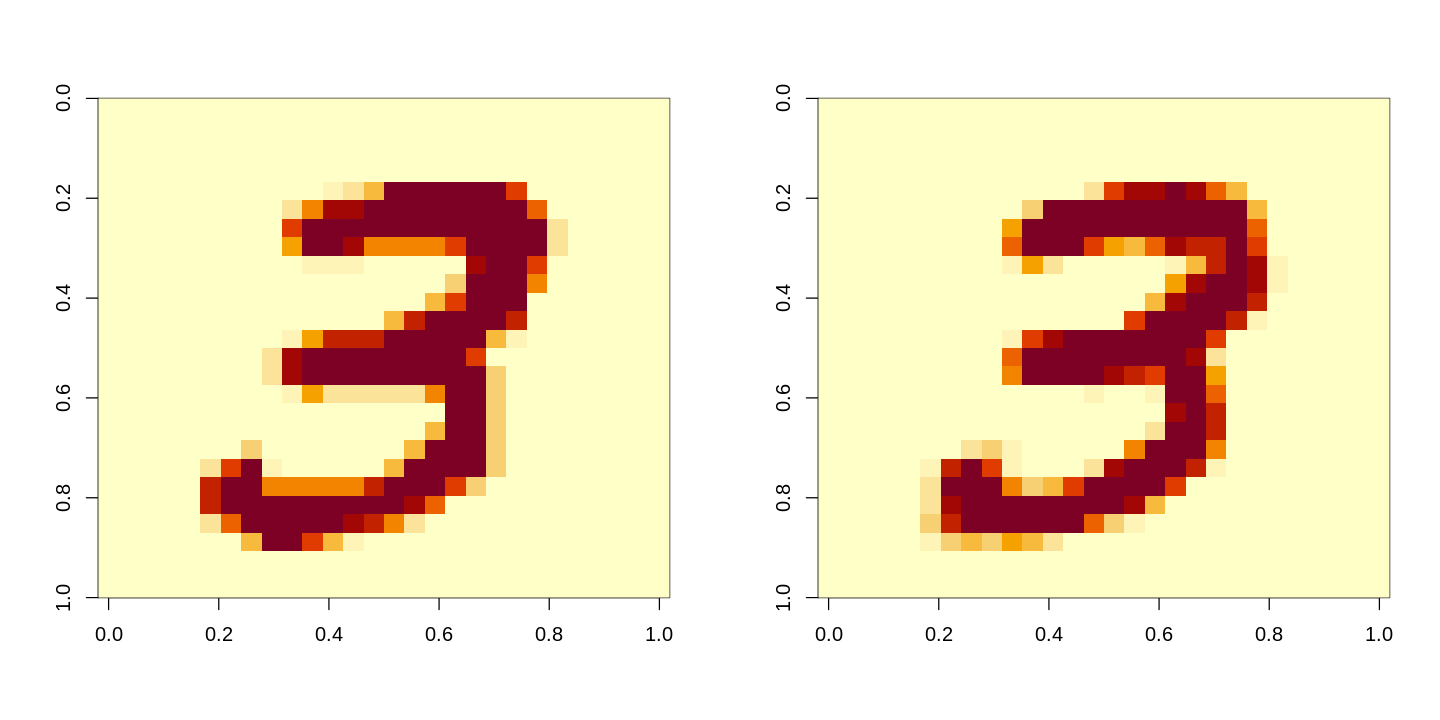

[1] "Epoch 21"
[1] "Training accuracy: 0.93748"
[1] "Validation accuracy: 0.9314"


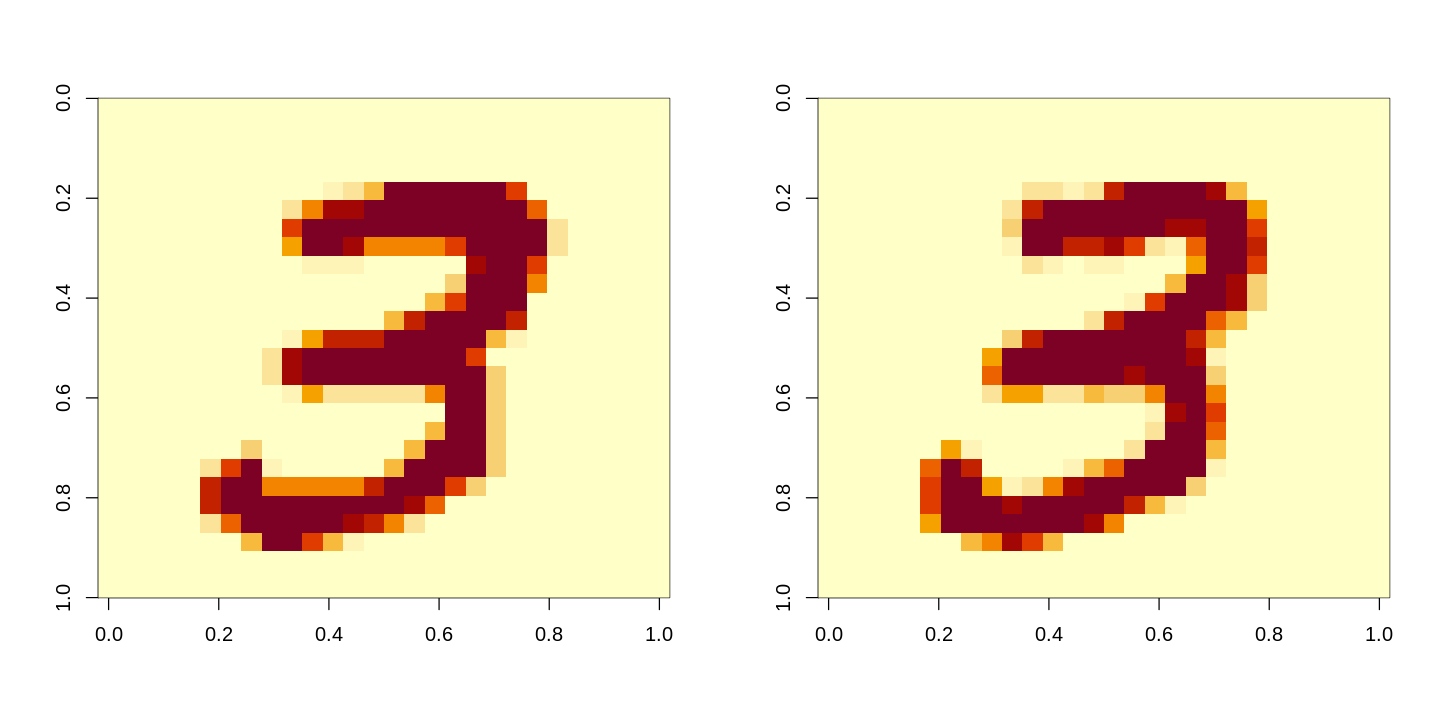

[1] "Epoch 22"
[1] "Training accuracy: 0.9371"
[1] "Validation accuracy: 0.9304"


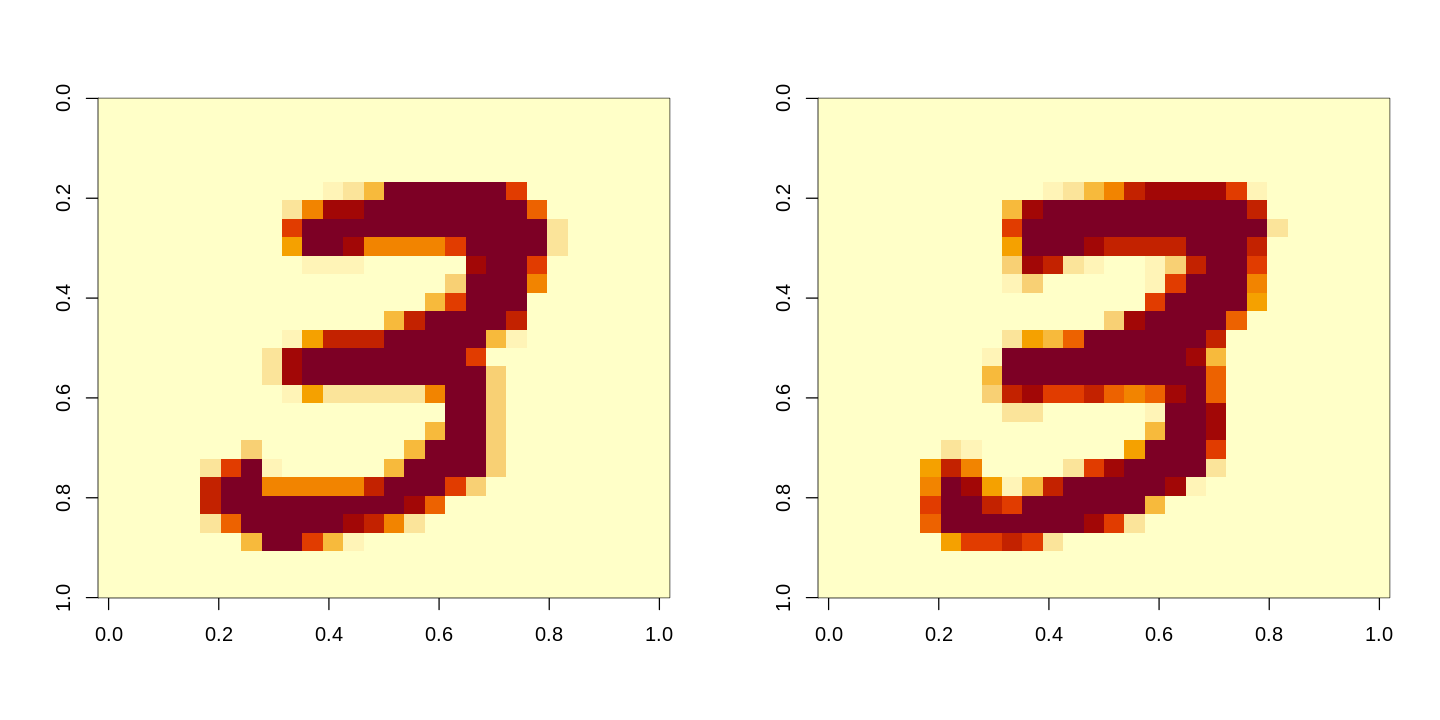

[1] "Epoch 23"
[1] "Training accuracy: 0.9385"
[1] "Validation accuracy: 0.9307"


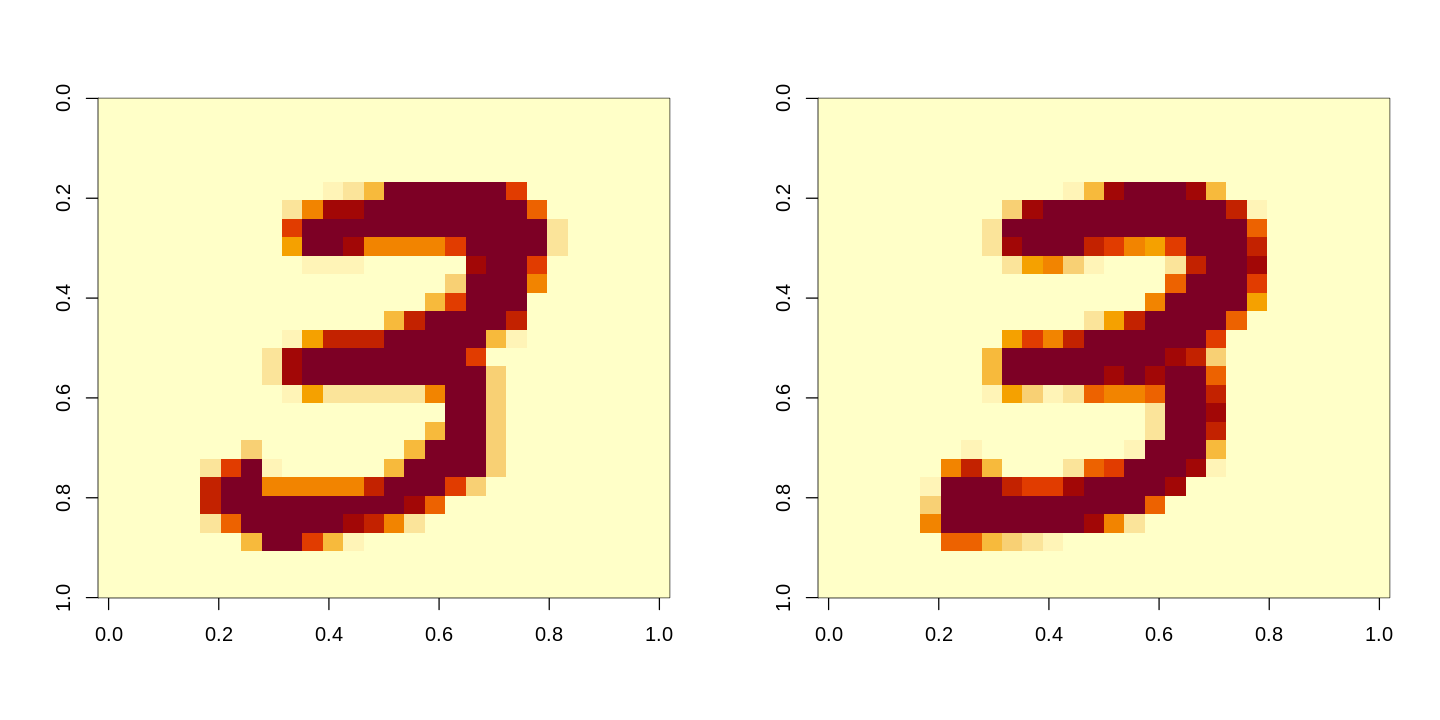

[1] "Epoch 24"
[1] "Training accuracy: 0.93738"
[1] "Validation accuracy: 0.9273"


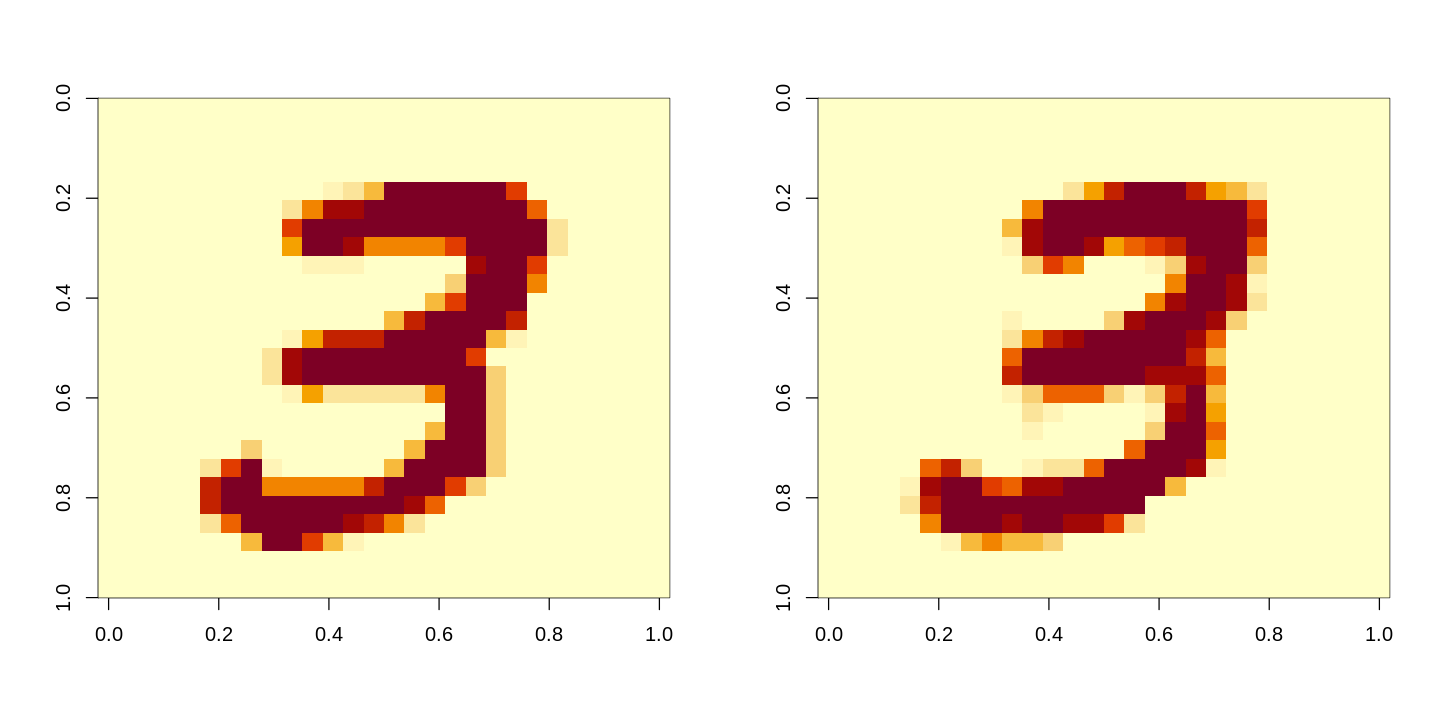

[1] "Epoch 25"
[1] "Training accuracy: 0.93696"
[1] "Validation accuracy: 0.9291"


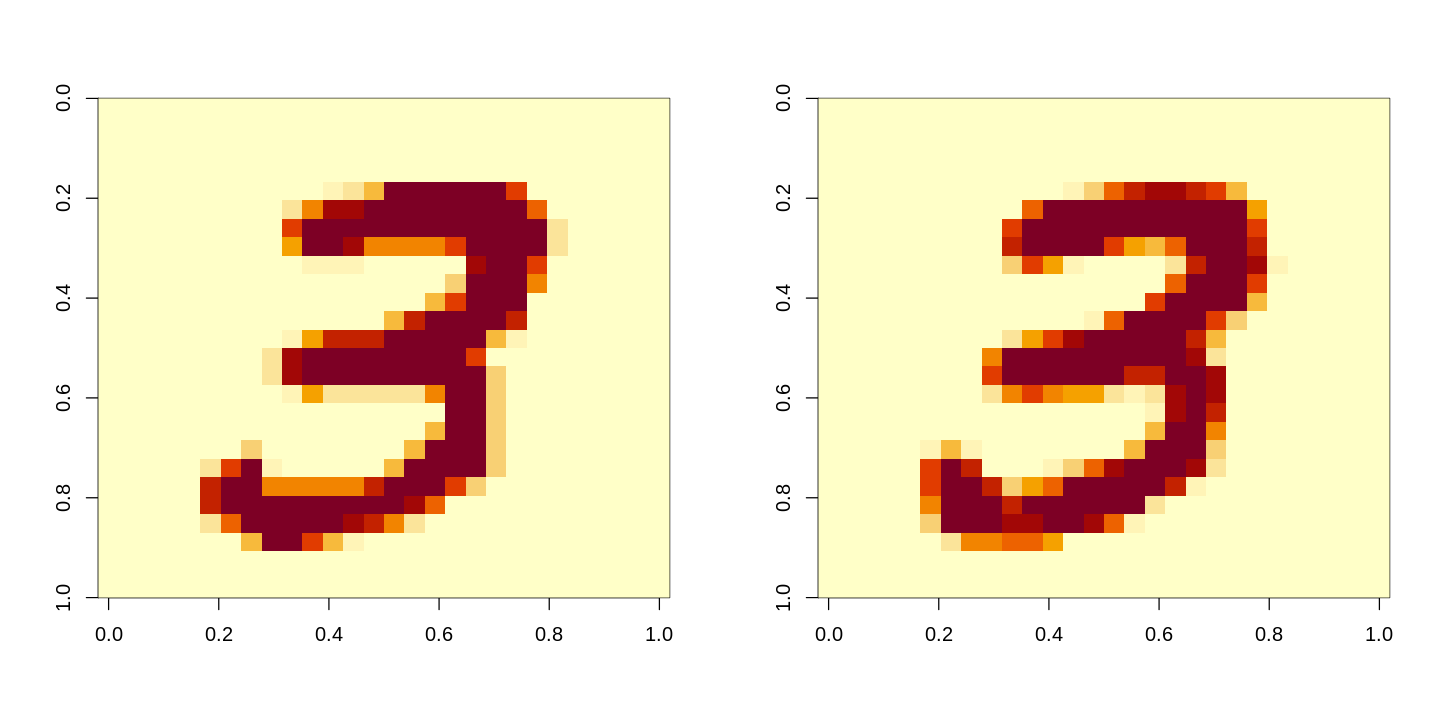

[1] "Epoch 26"
[1] "Training accuracy: 0.93798"
[1] "Validation accuracy: 0.931"


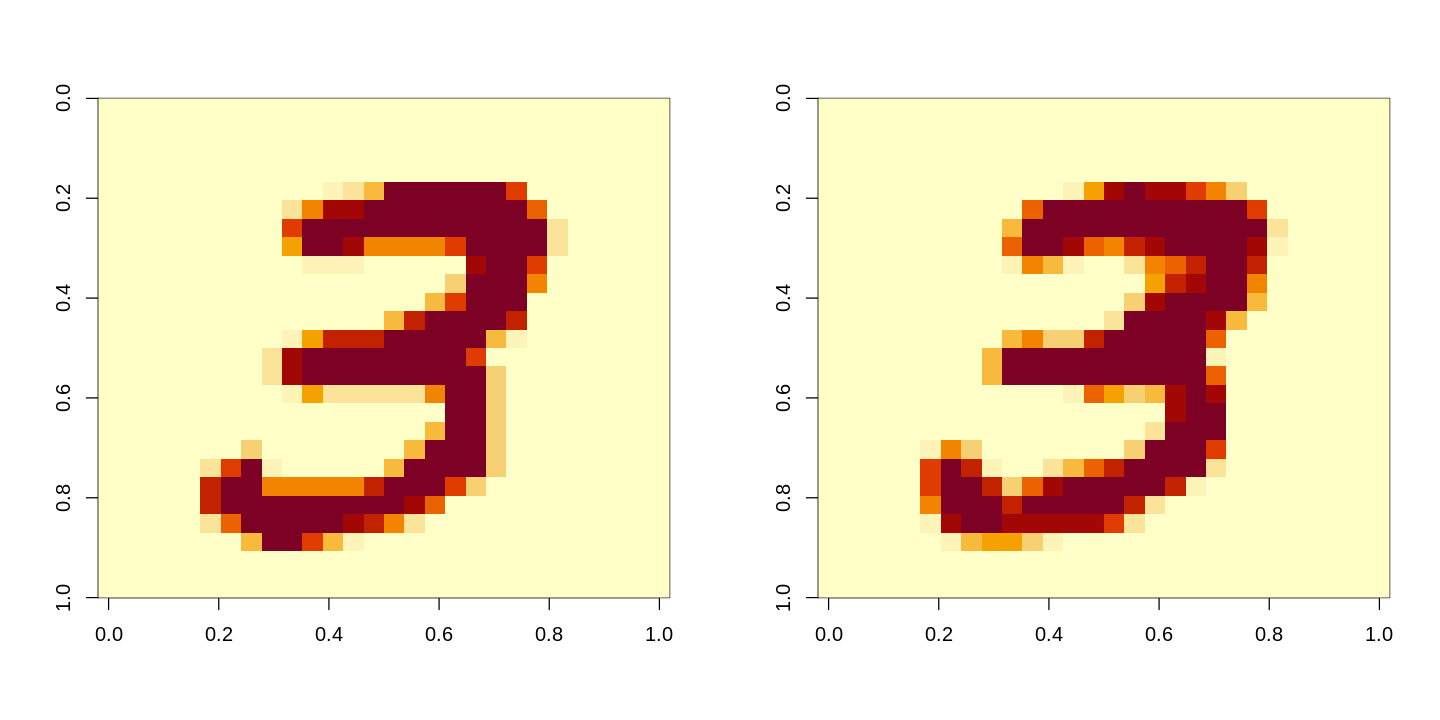

[1] "Epoch 27"
[1] "Training accuracy: 0.93738"
[1] "Validation accuracy: 0.926"


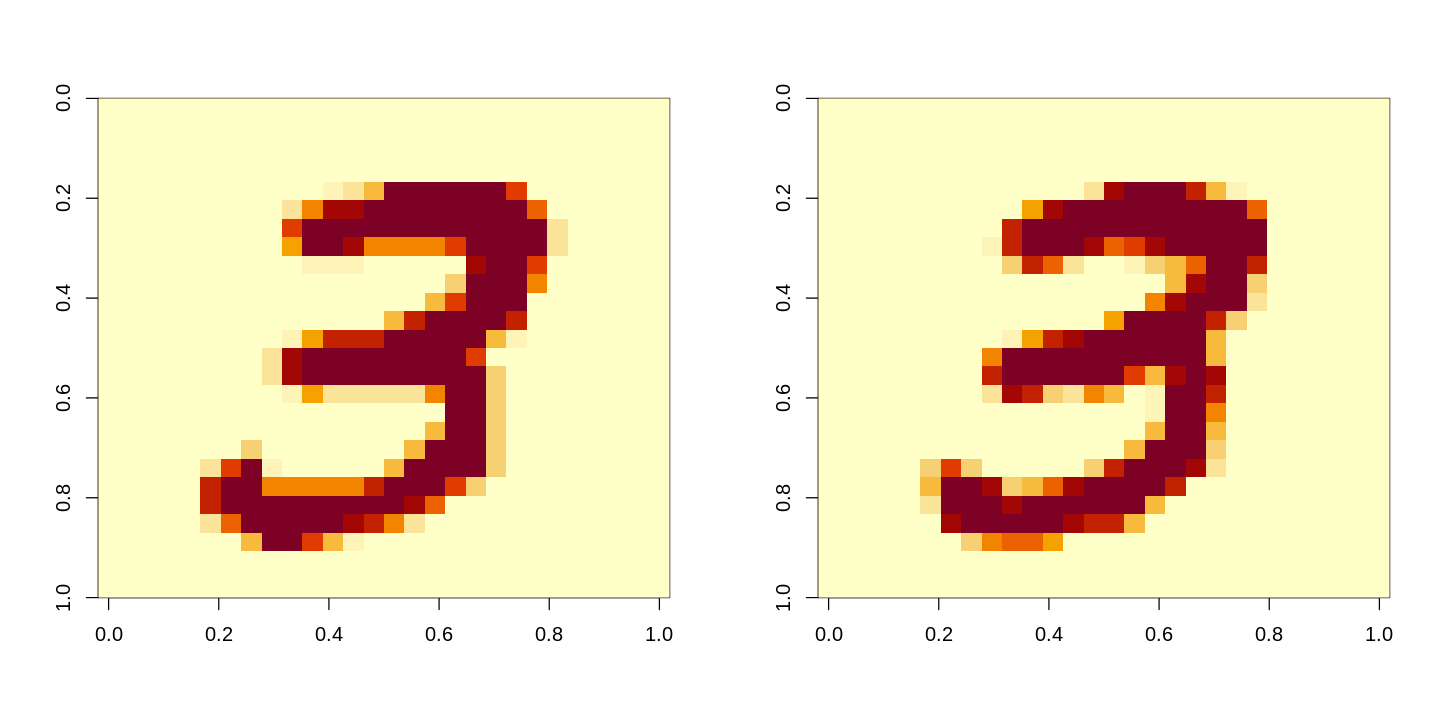

[1] "Epoch 28"
[1] "Training accuracy: 0.93566"
[1] "Validation accuracy: 0.9262"


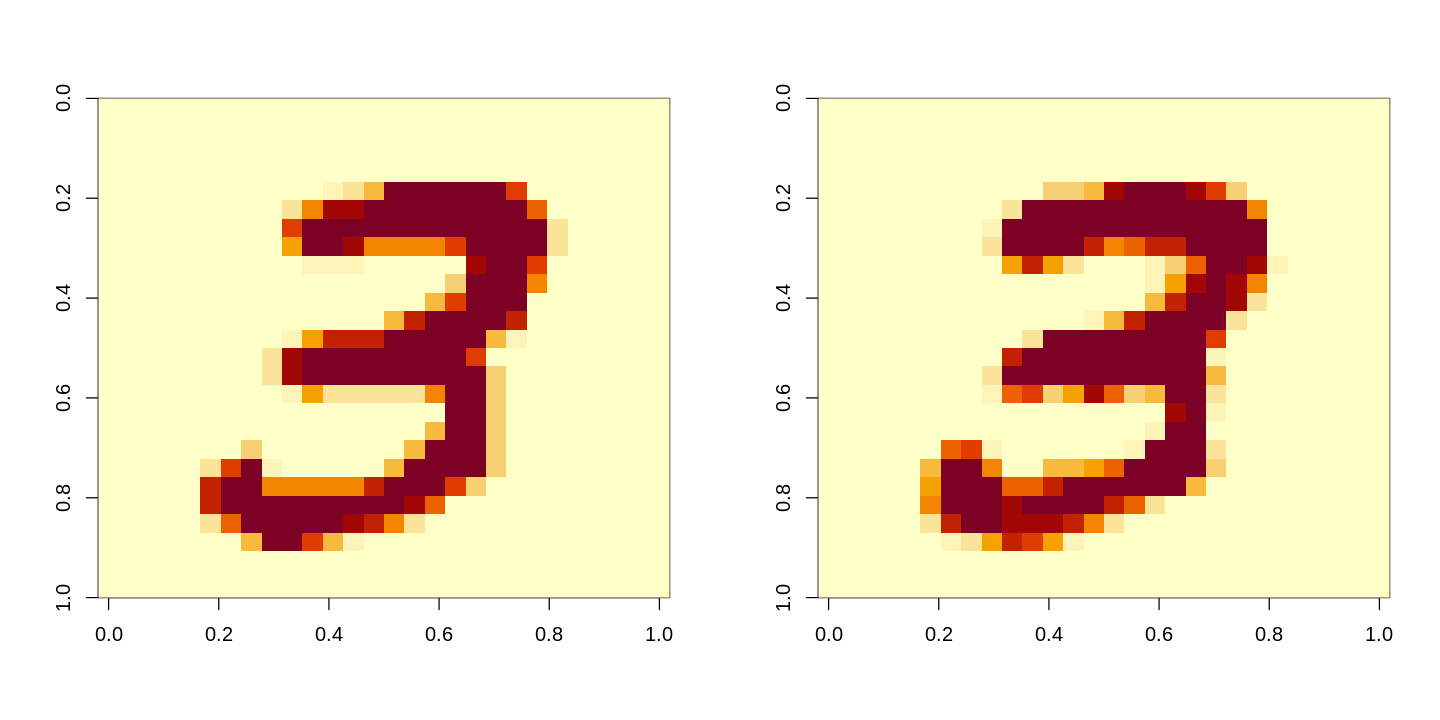

[1] "Epoch 29"
[1] "Training accuracy: 0.93726"
[1] "Validation accuracy: 0.9289"


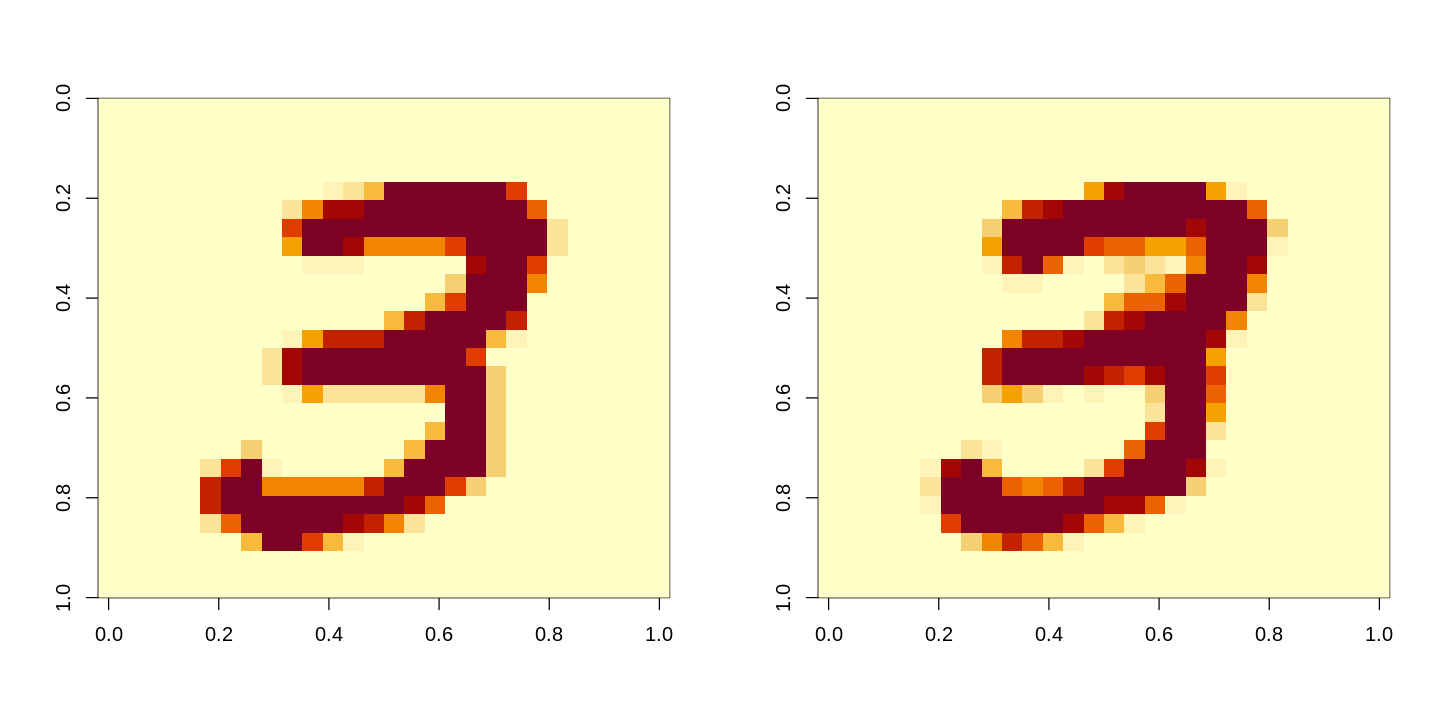

[1] "Epoch 30"
[1] "Training accuracy: 0.93708"
[1] "Validation accuracy: 0.9302"


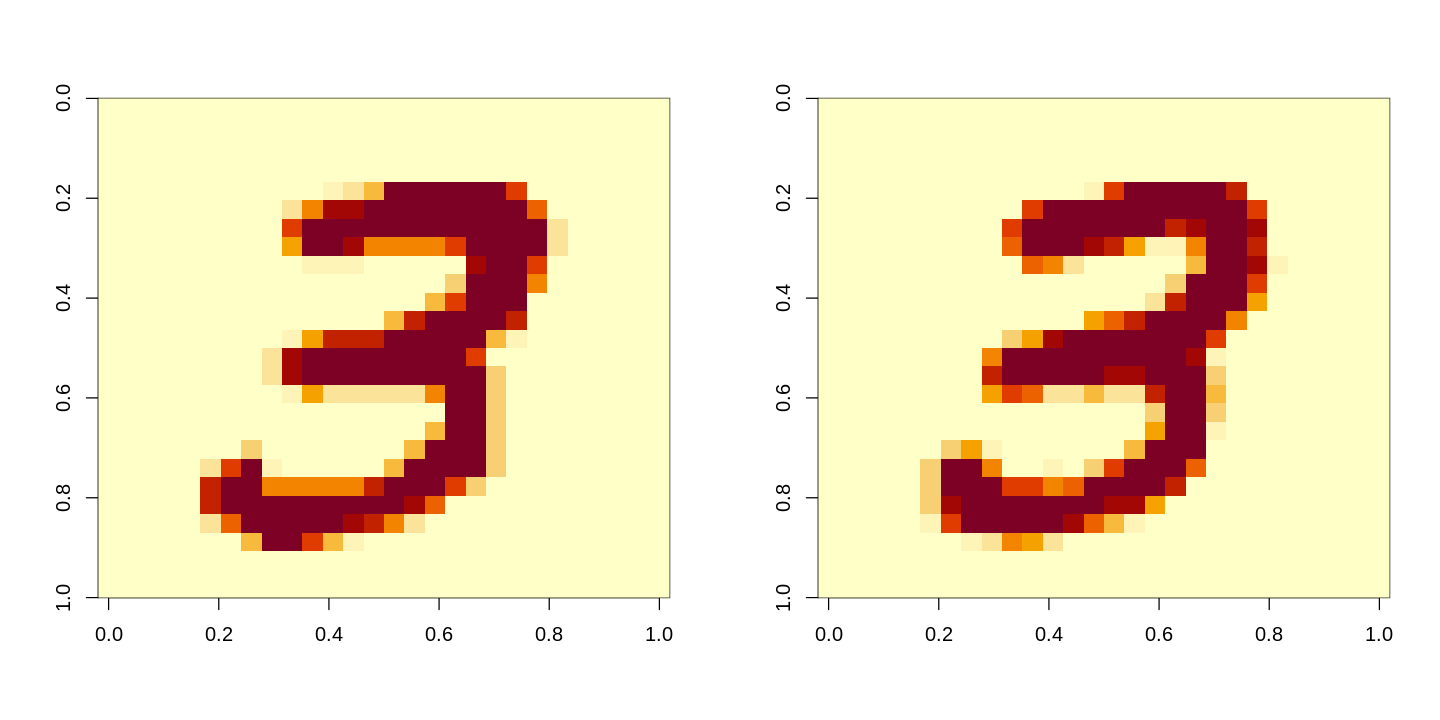

[1] "Epoch 31"
[1] "Training accuracy: 0.9354"
[1] "Validation accuracy: 0.9285"


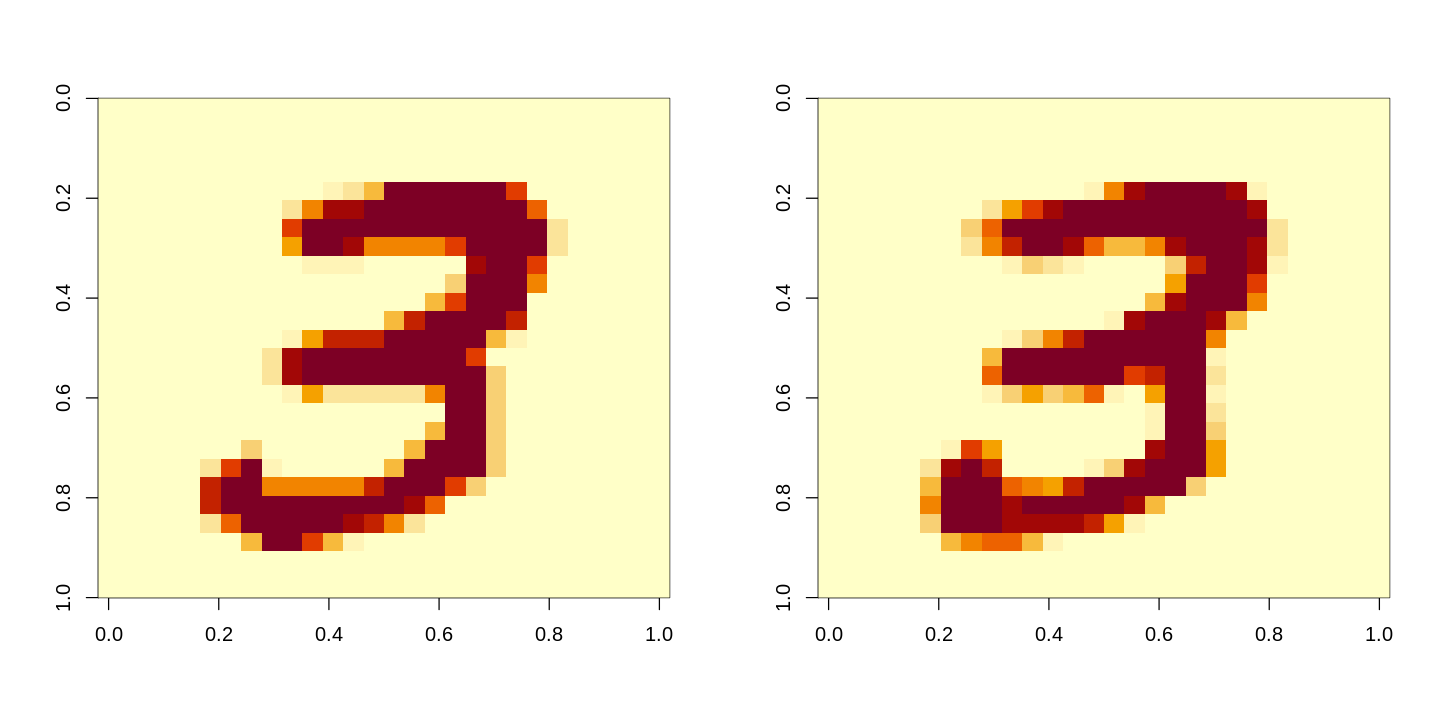

[1] "Epoch 32"
[1] "Training accuracy: 0.93738"
[1] "Validation accuracy: 0.9273"


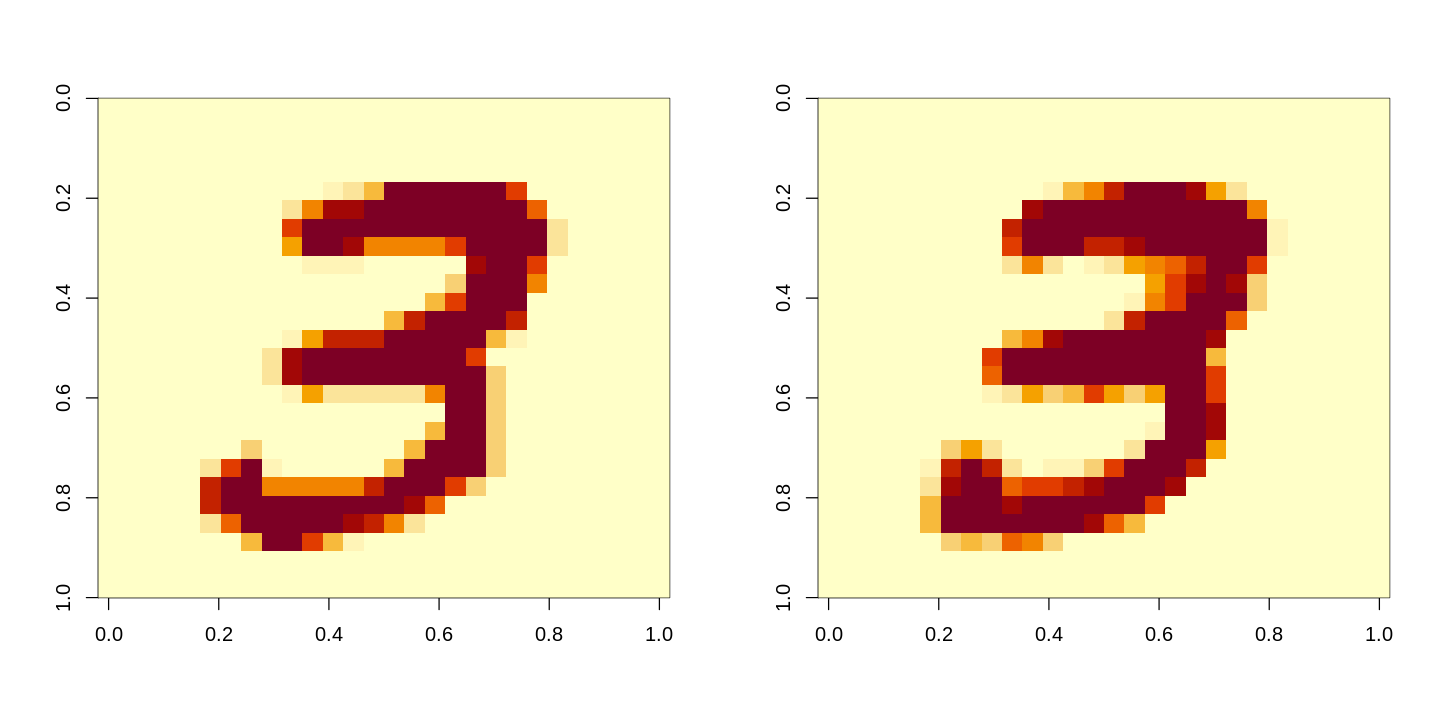

[1] "Epoch 33"
[1] "Training accuracy: 0.93628"
[1] "Validation accuracy: 0.9274"


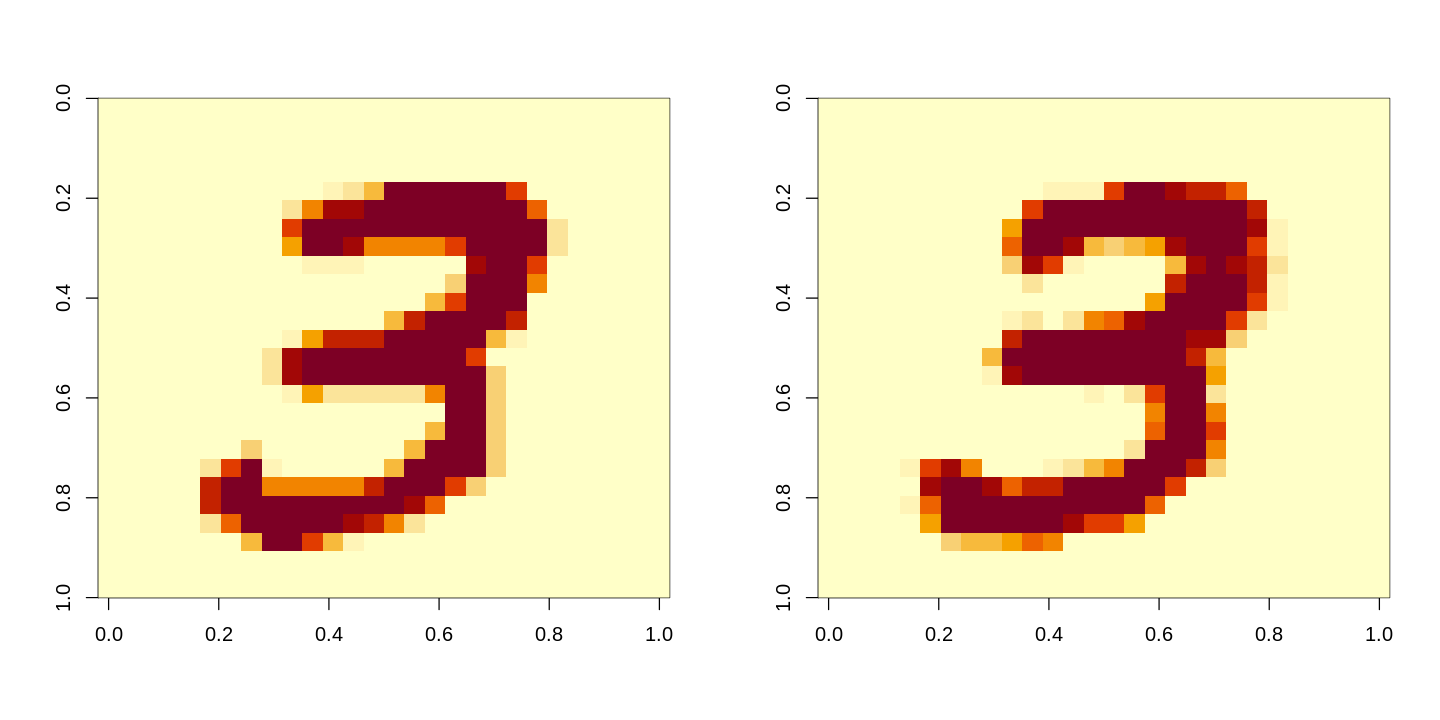

[1] "Epoch 34"
[1] "Training accuracy: 0.93784"
[1] "Validation accuracy: 0.93"


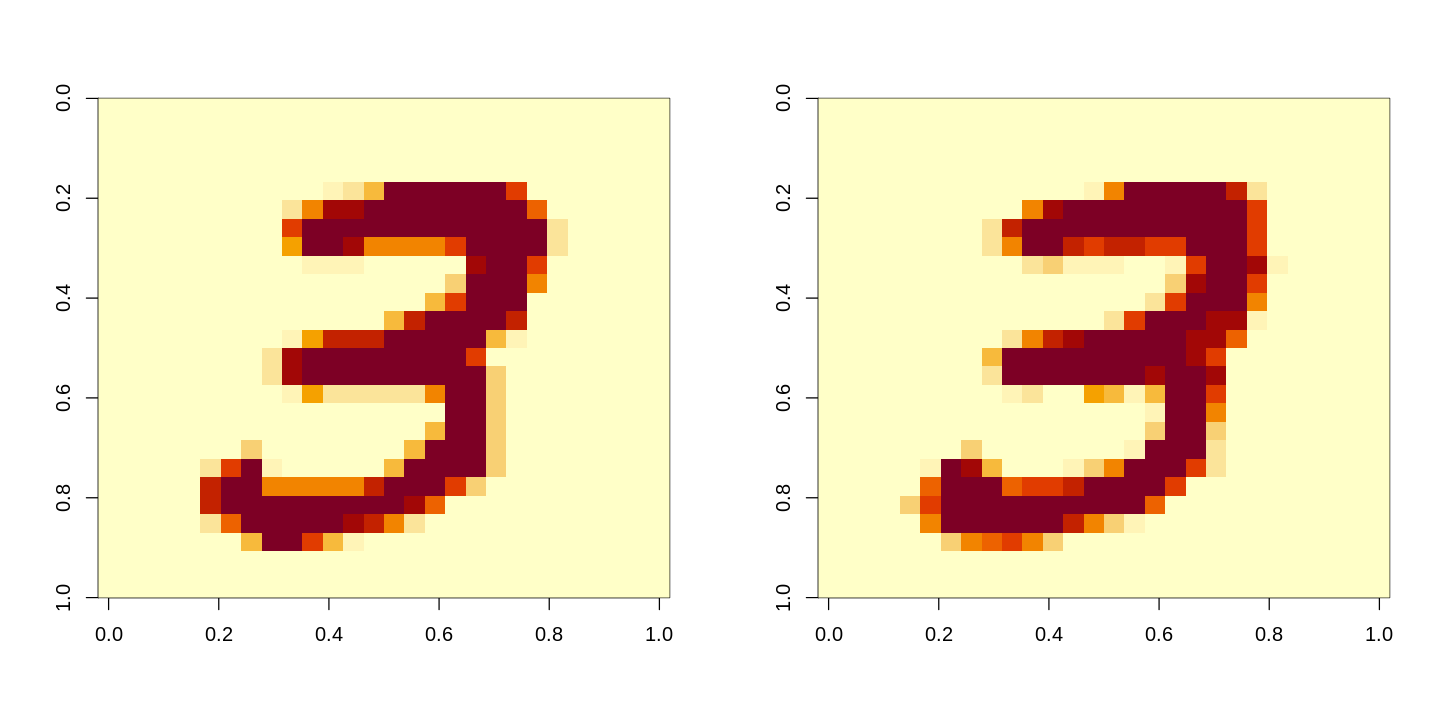

[1] "Epoch 35"
[1] "Training accuracy: 0.9322"
[1] "Validation accuracy: 0.9241"


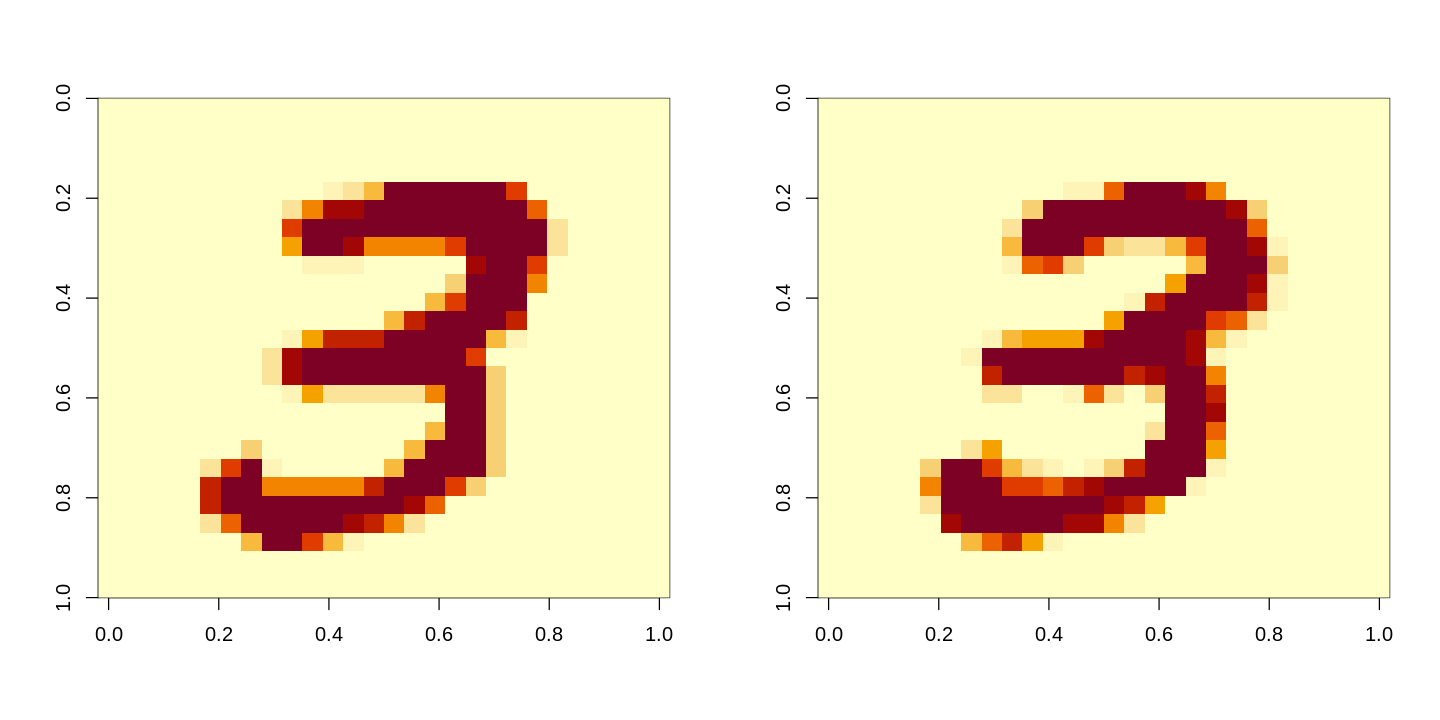

[1] "Epoch 36"
[1] "Training accuracy: 0.9339"
[1] "Validation accuracy: 0.927"


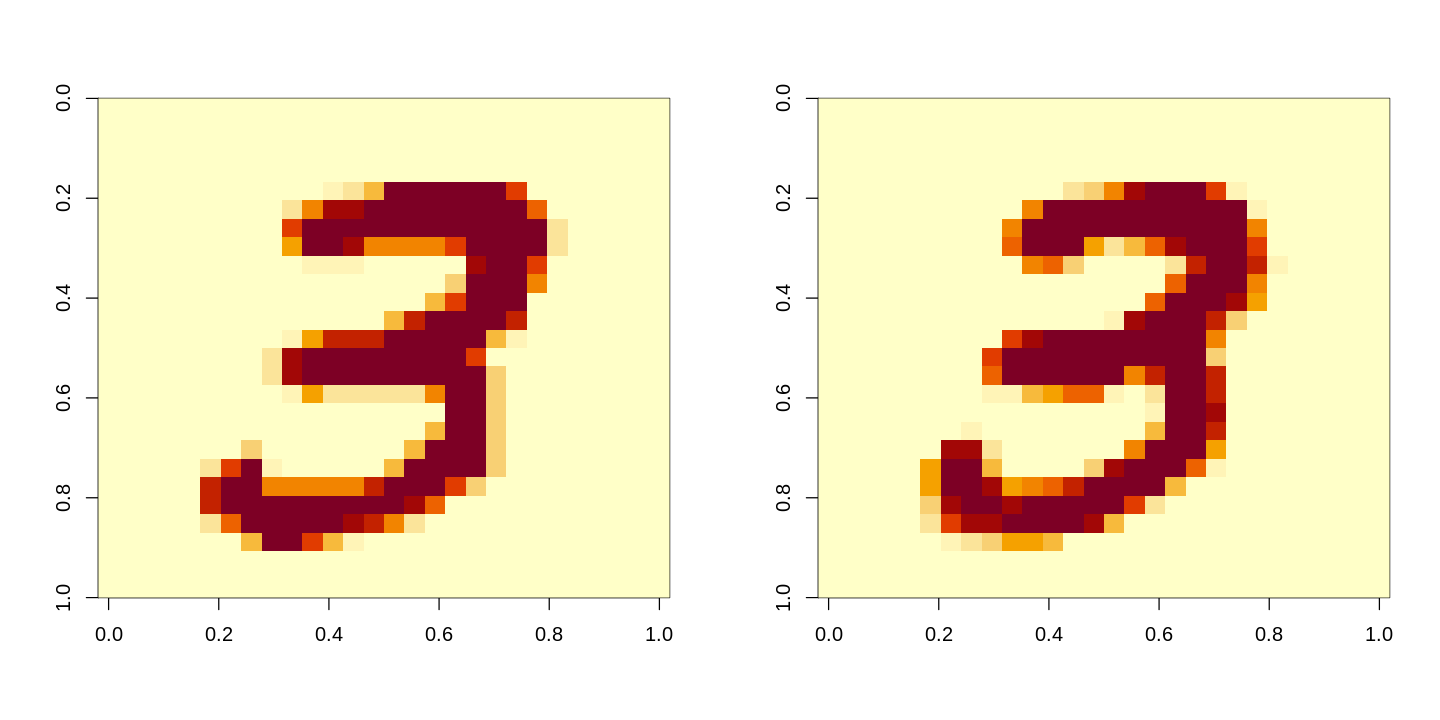

[1] "Epoch 37"
[1] "Training accuracy: 0.93324"
[1] "Validation accuracy: 0.9255"


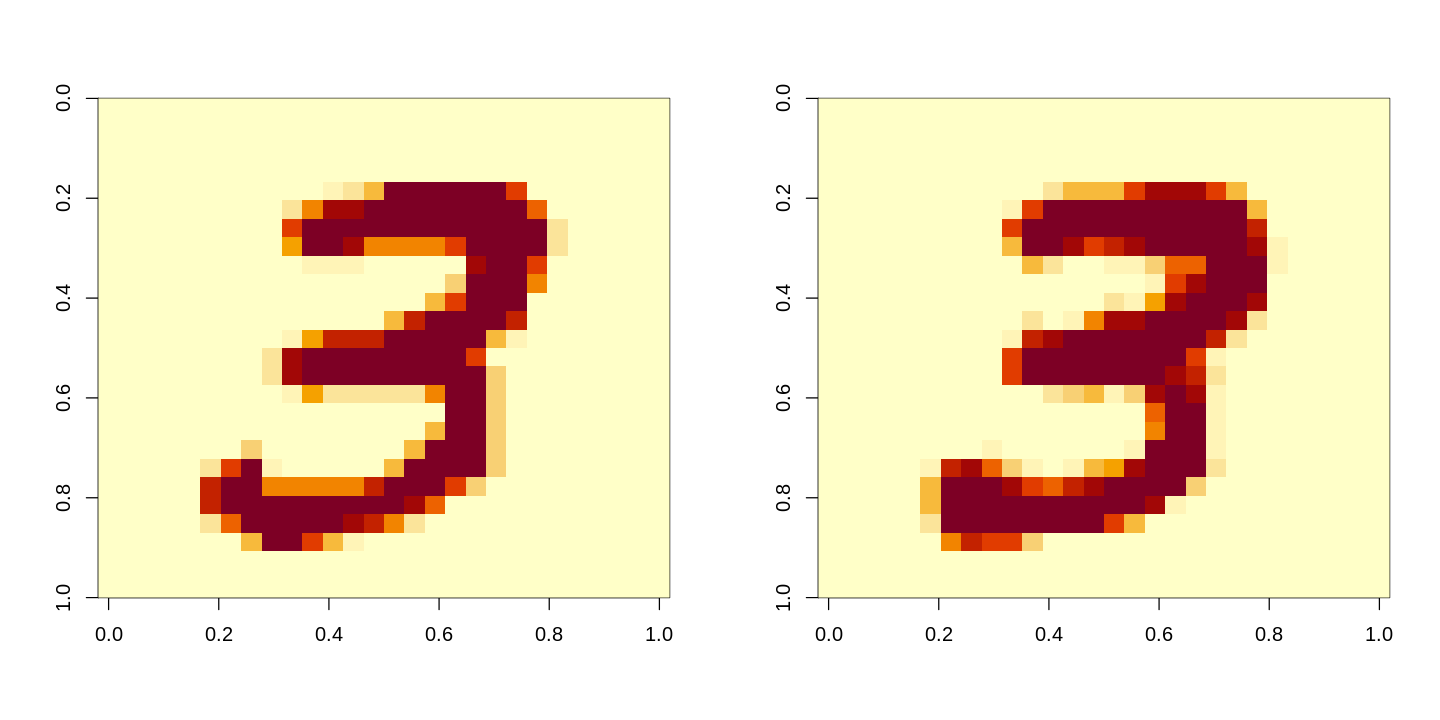

[1] "Epoch 38"
[1] "Training accuracy: 0.93776"
[1] "Validation accuracy: 0.9309"


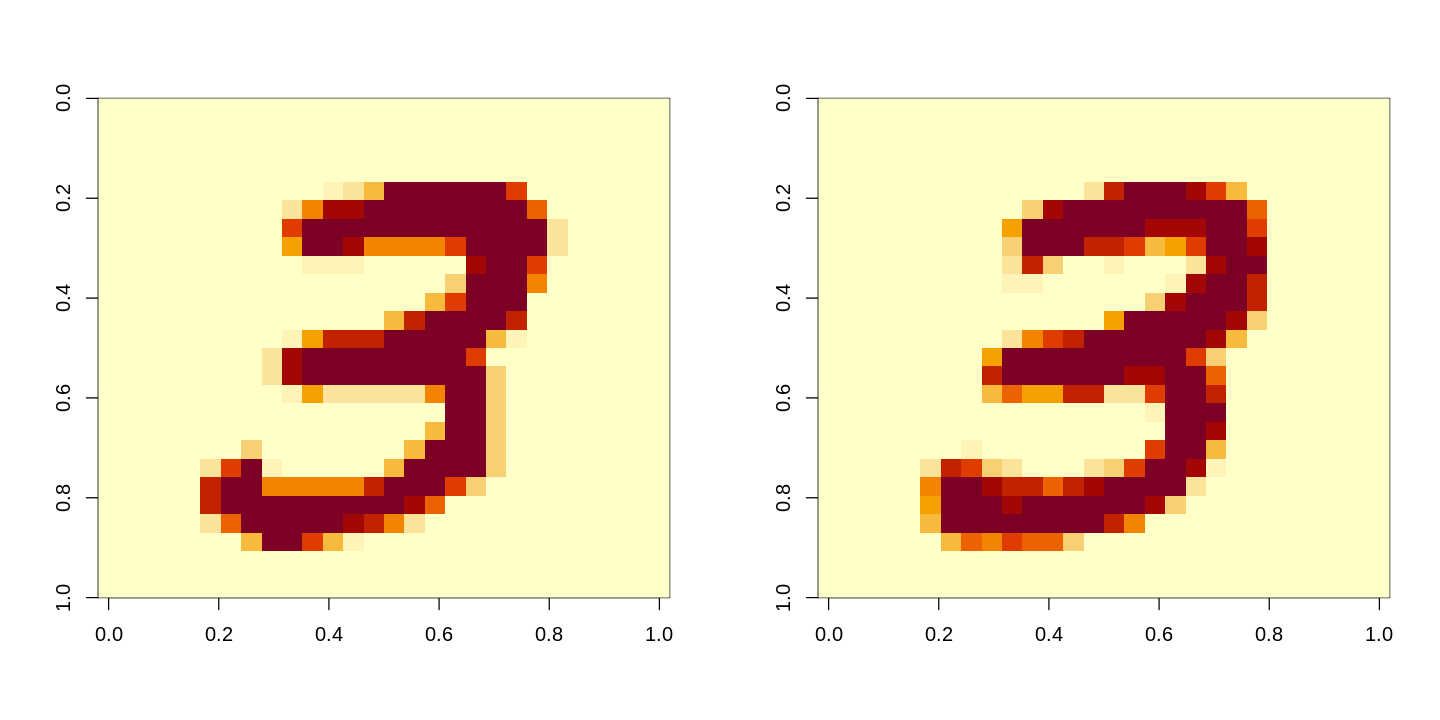

[1] "Epoch 39"
[1] "Training accuracy: 0.93582"
[1] "Validation accuracy: 0.9283"


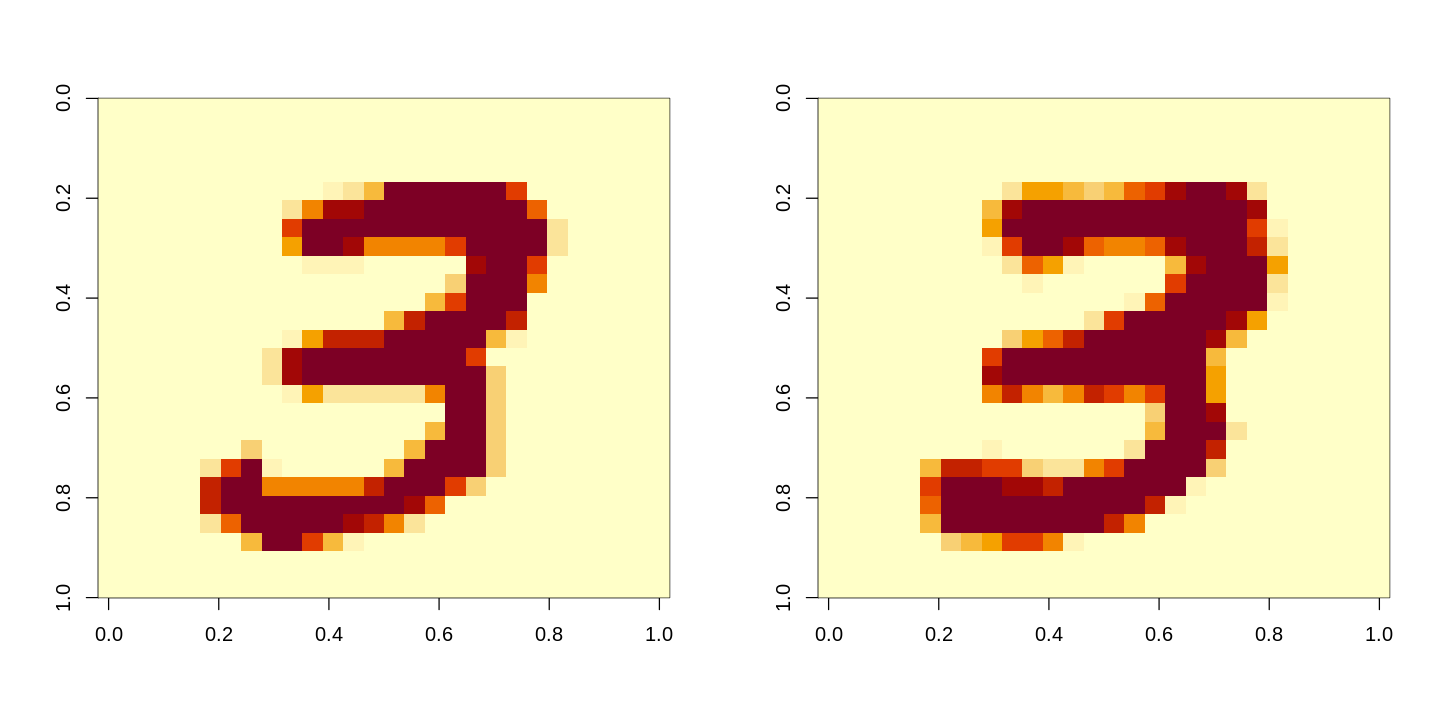

[1] "Epoch 40"
[1] "Training accuracy: 0.93502"
[1] "Validation accuracy: 0.9292"


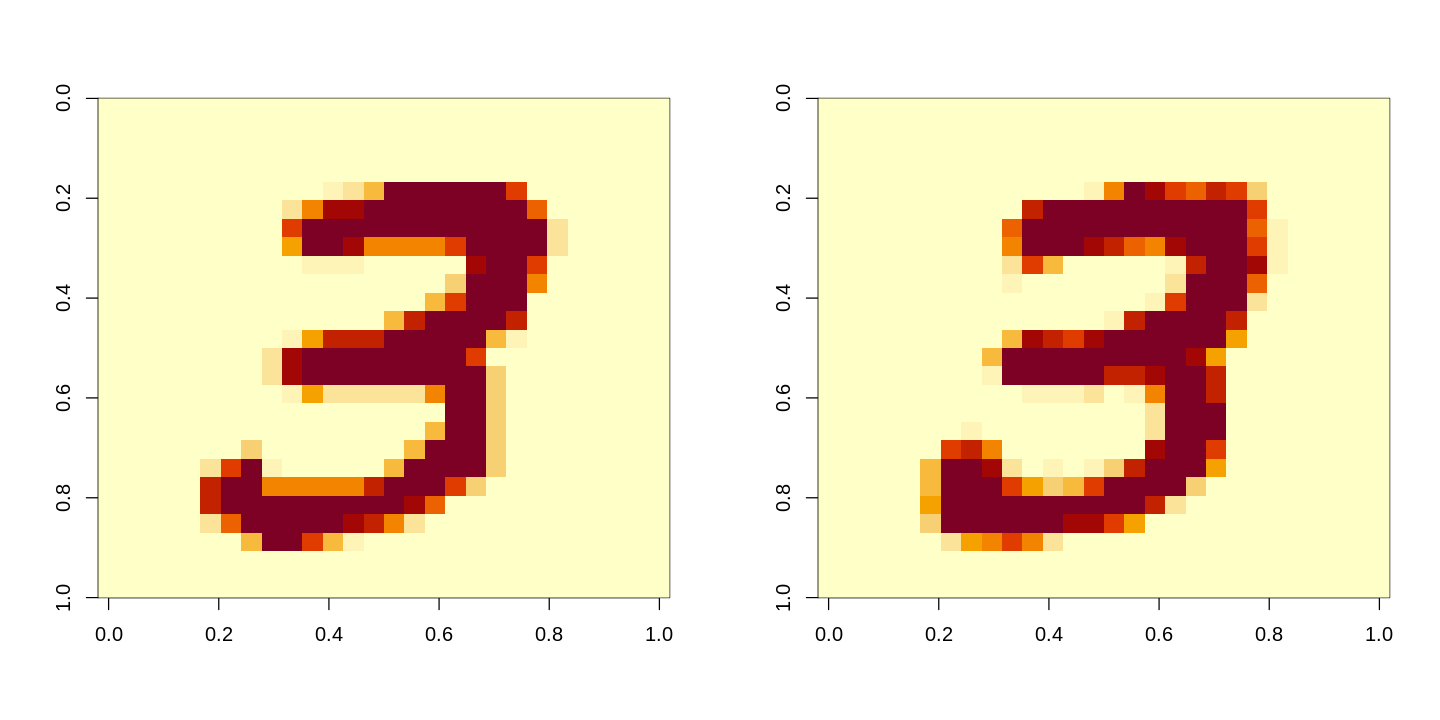

[1] "Epoch 41"
[1] "Training accuracy: 0.93144"
[1] "Validation accuracy: 0.9231"


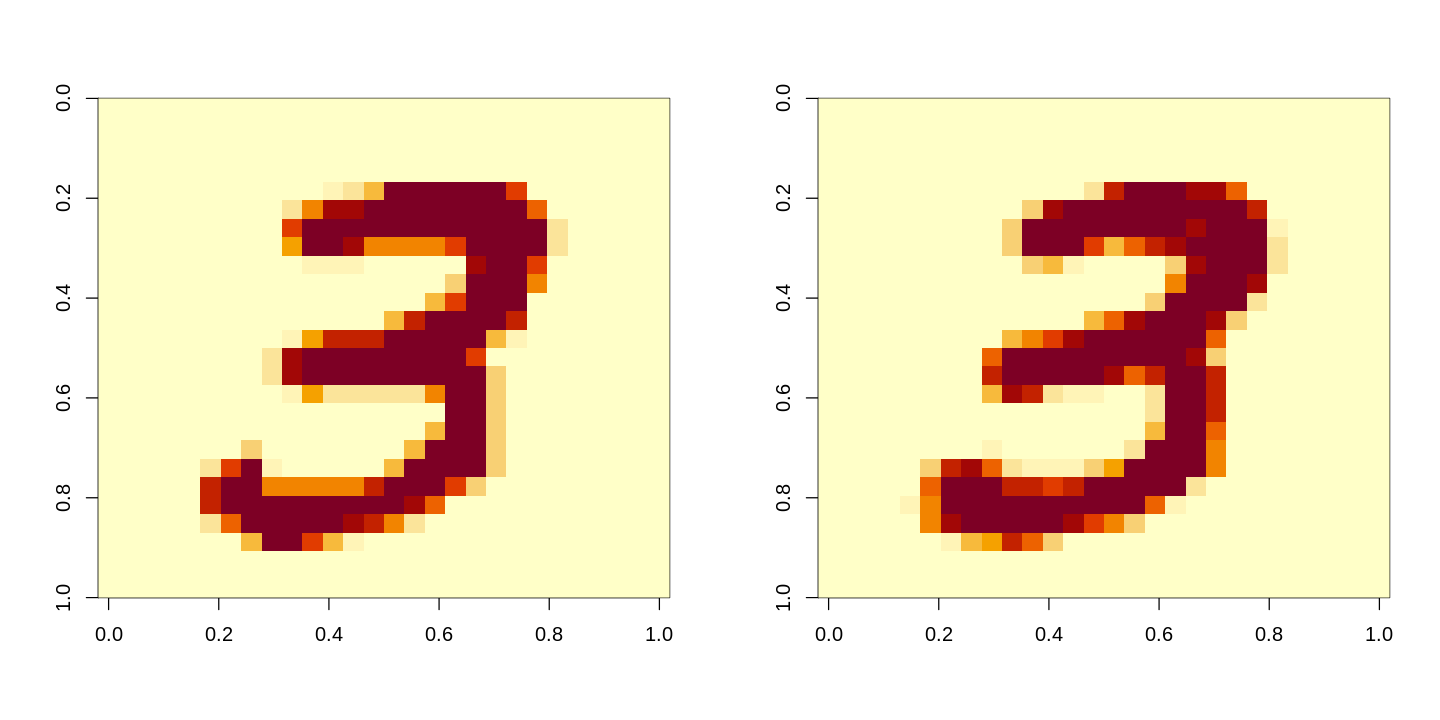

[1] "Epoch 42"
[1] "Training accuracy: 0.93494"
[1] "Validation accuracy: 0.9286"


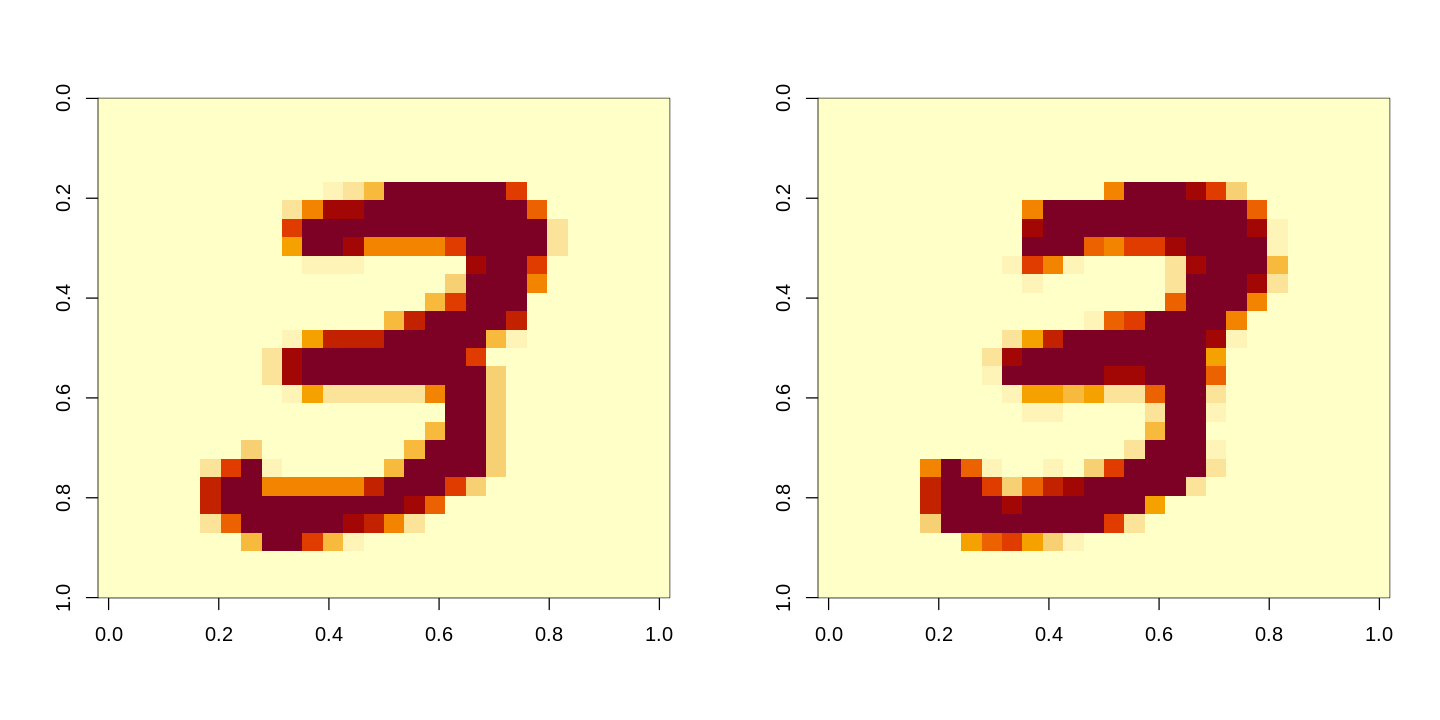

[1] "Epoch 43"
[1] "Training accuracy: 0.93378"
[1] "Validation accuracy: 0.9274"


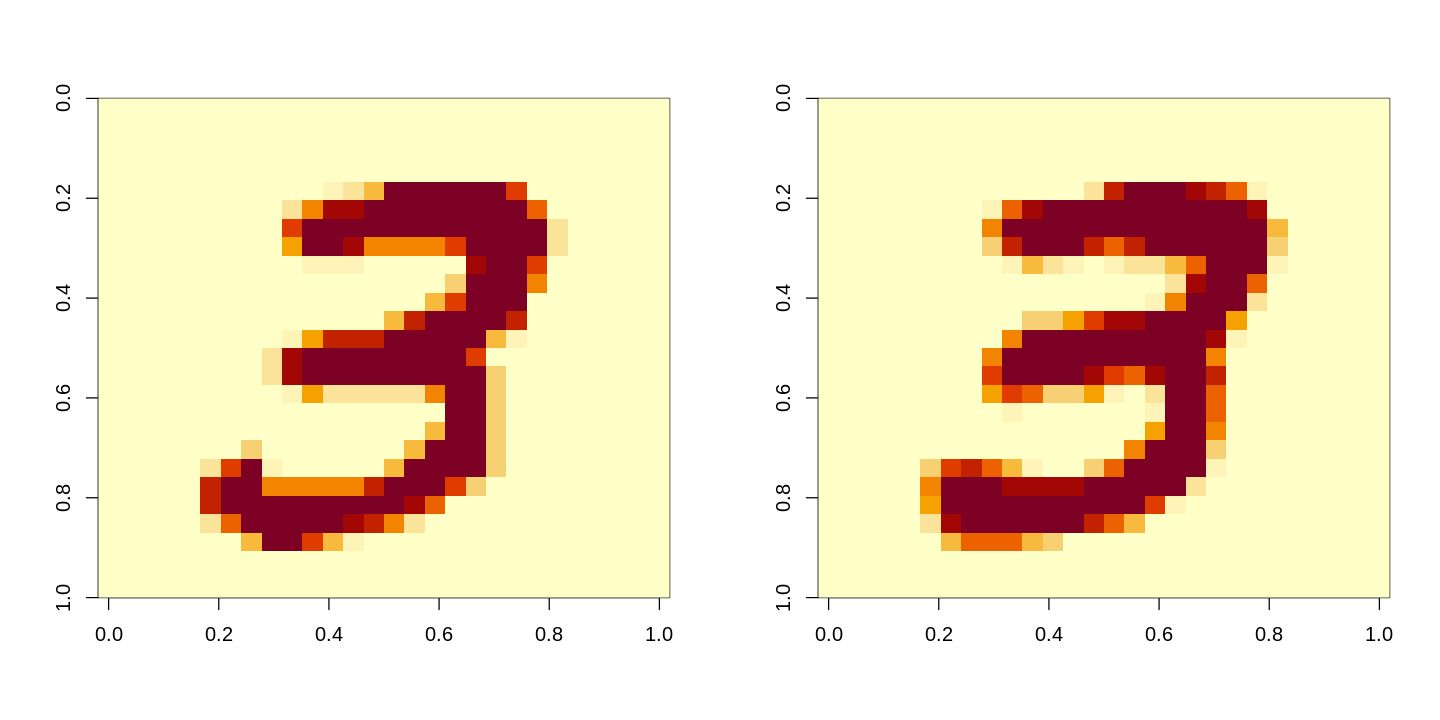

[1] "Epoch 44"
[1] "Training accuracy: 0.93392"
[1] "Validation accuracy: 0.9263"


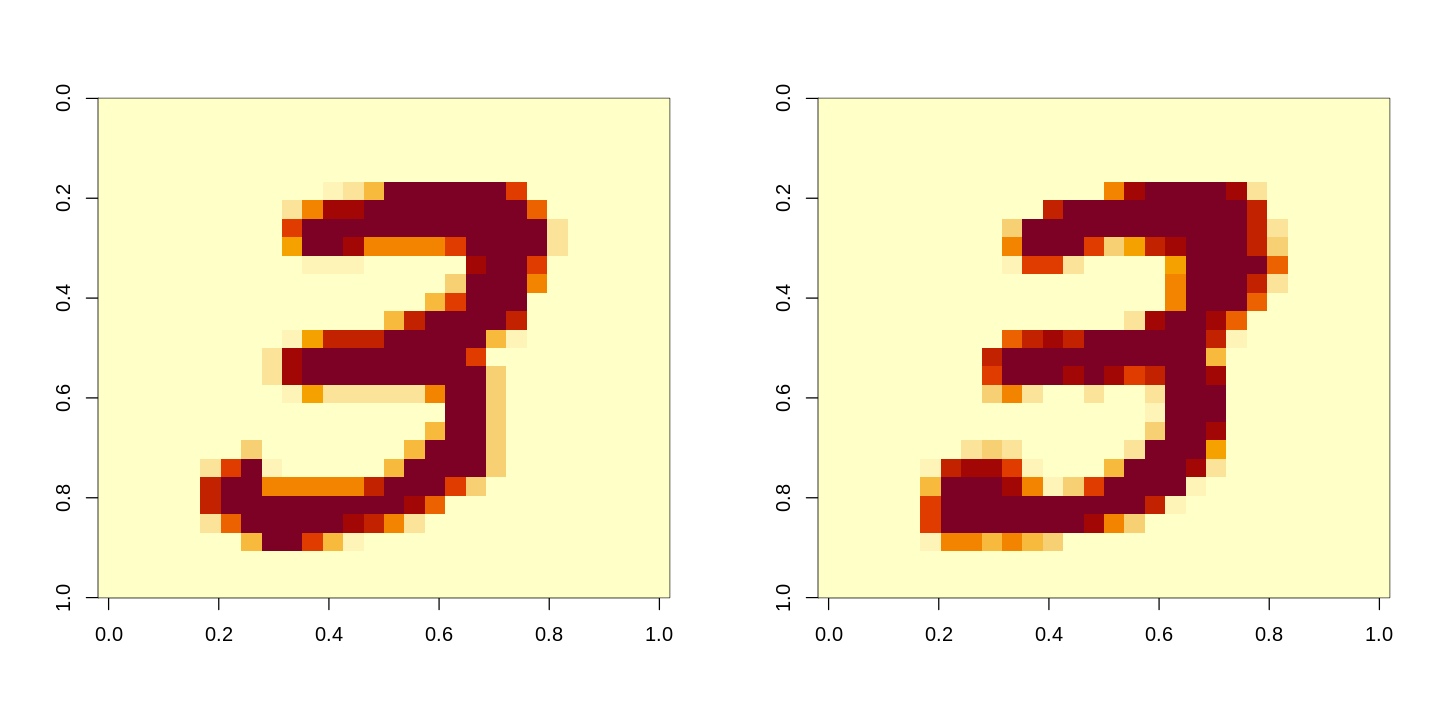

[1] "Epoch 45"
[1] "Training accuracy: 0.93318"
[1] "Validation accuracy: 0.9265"


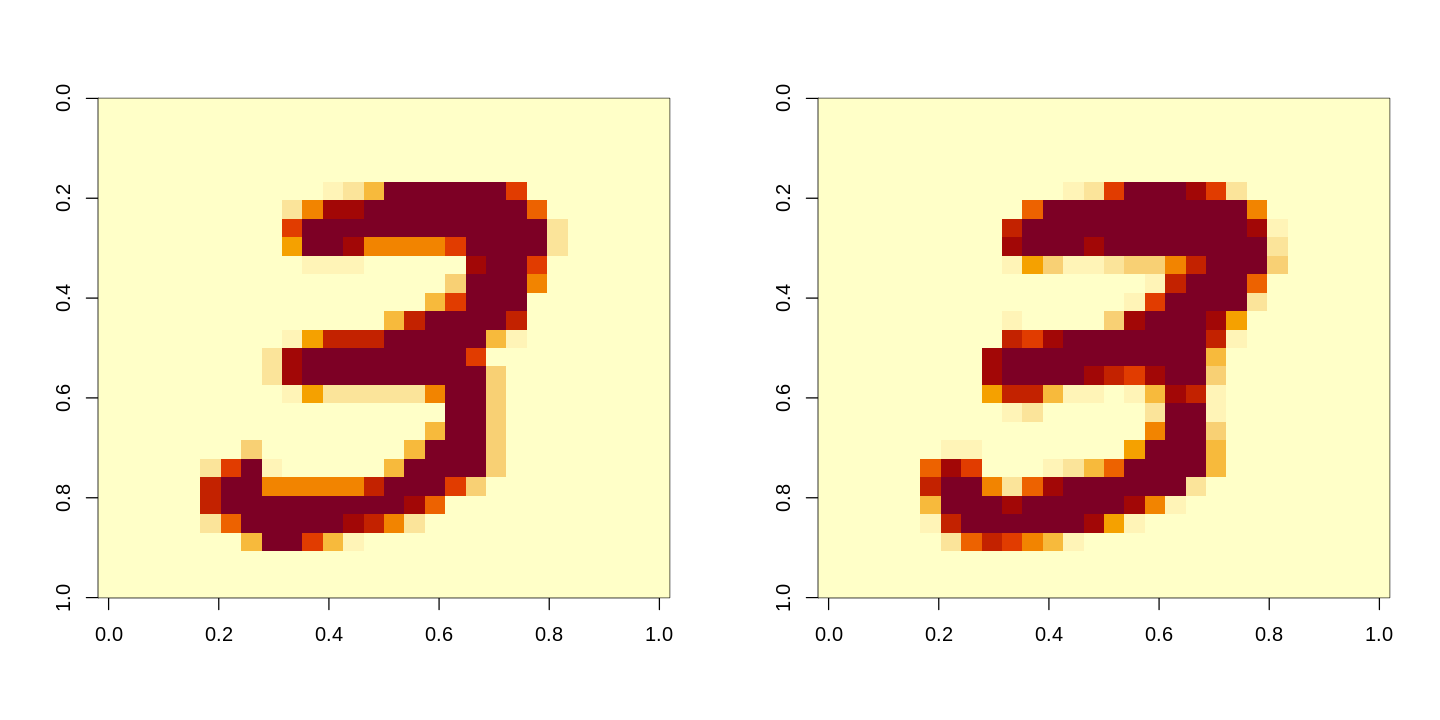

[1] "Epoch 46"
[1] "Training accuracy: 0.9307"
[1] "Validation accuracy: 0.9232"


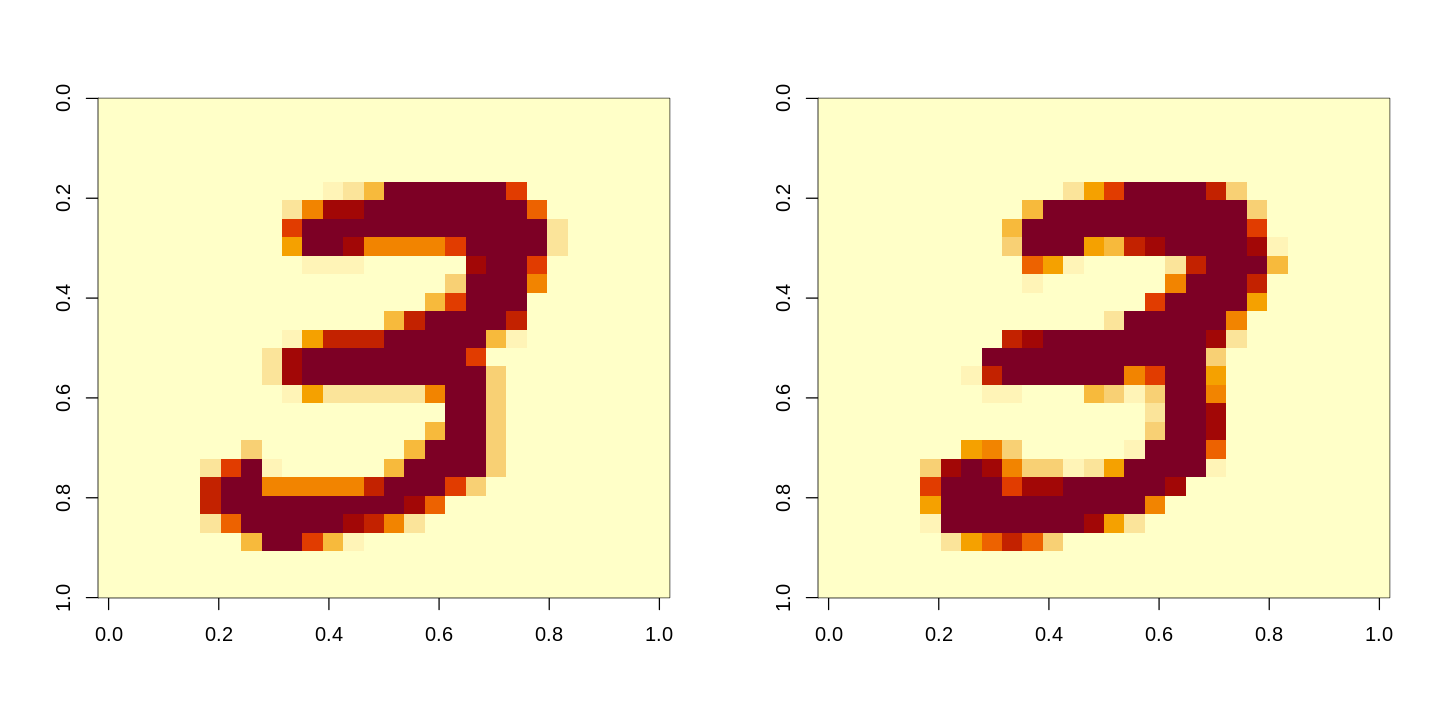

[1] "Epoch 47"
[1] "Training accuracy: 0.9334"
[1] "Validation accuracy: 0.9281"


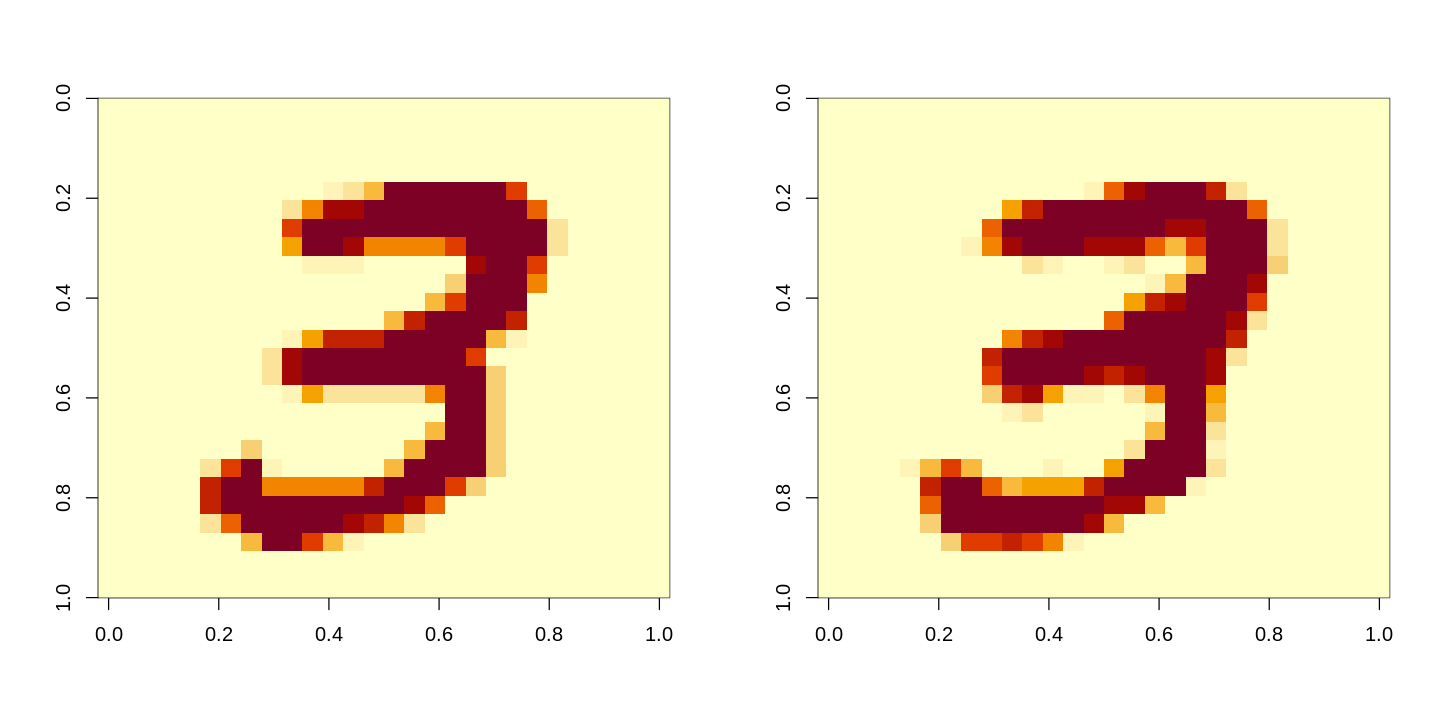

[1] "Epoch 48"
[1] "Training accuracy: 0.92816"
[1] "Validation accuracy: 0.9215"


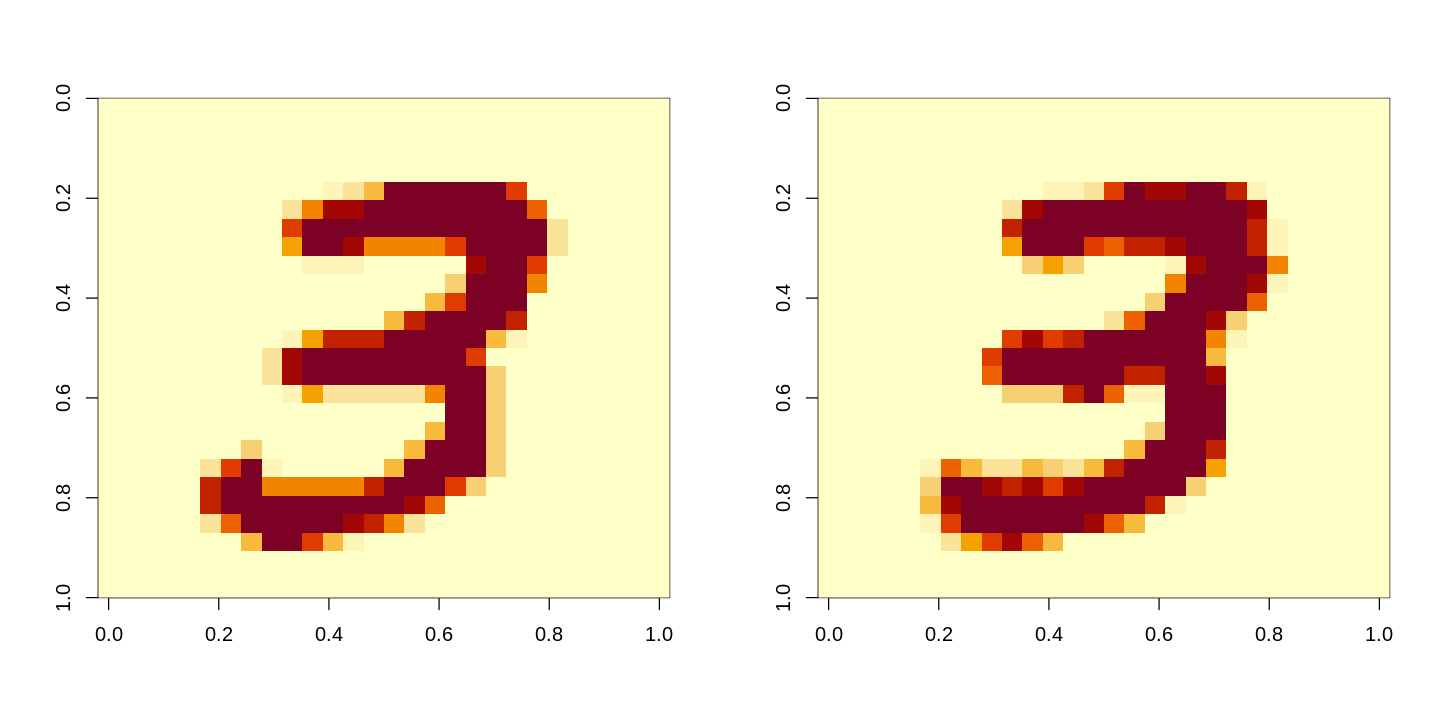

[1] "Epoch 49"
[1] "Training accuracy: 0.92966"
[1] "Validation accuracy: 0.9229"


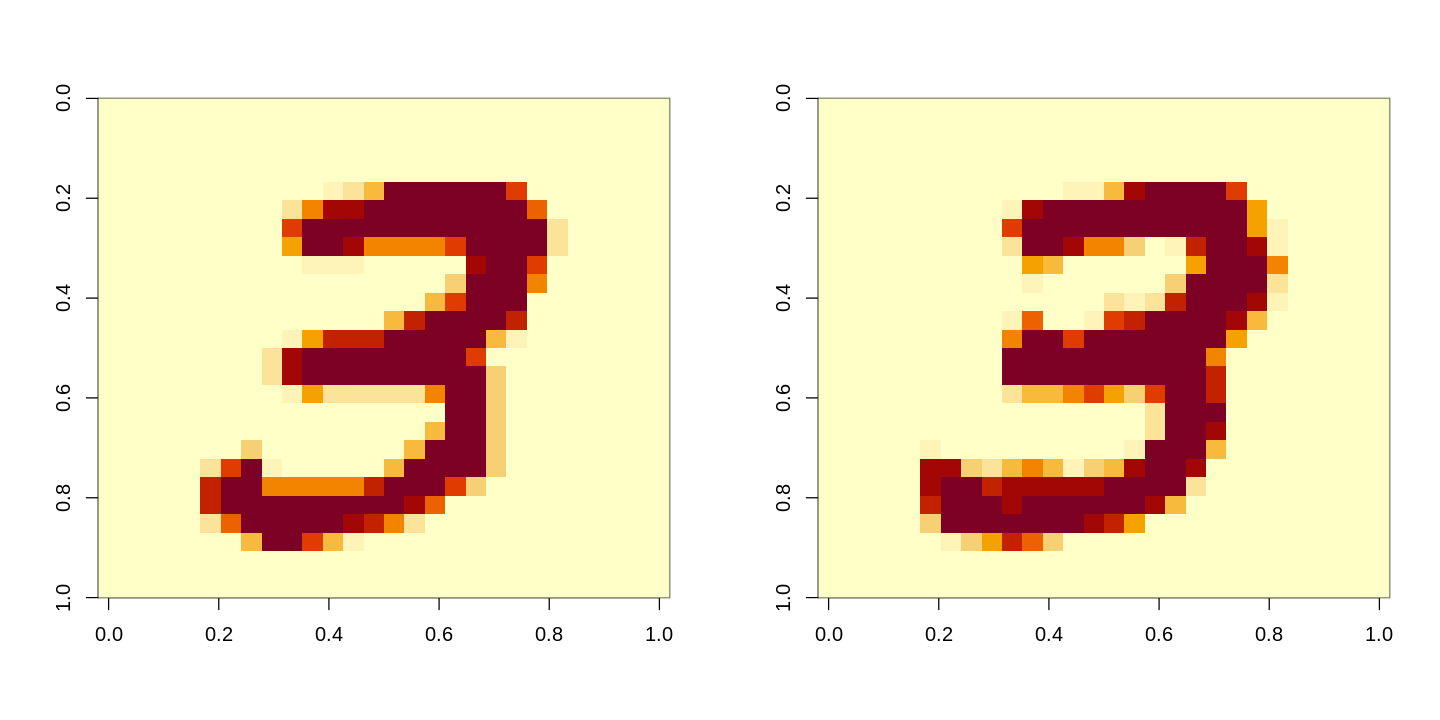

[1] "Epoch 50"
[1] "Training accuracy: 0.93254"
[1] "Validation accuracy: 0.9266"


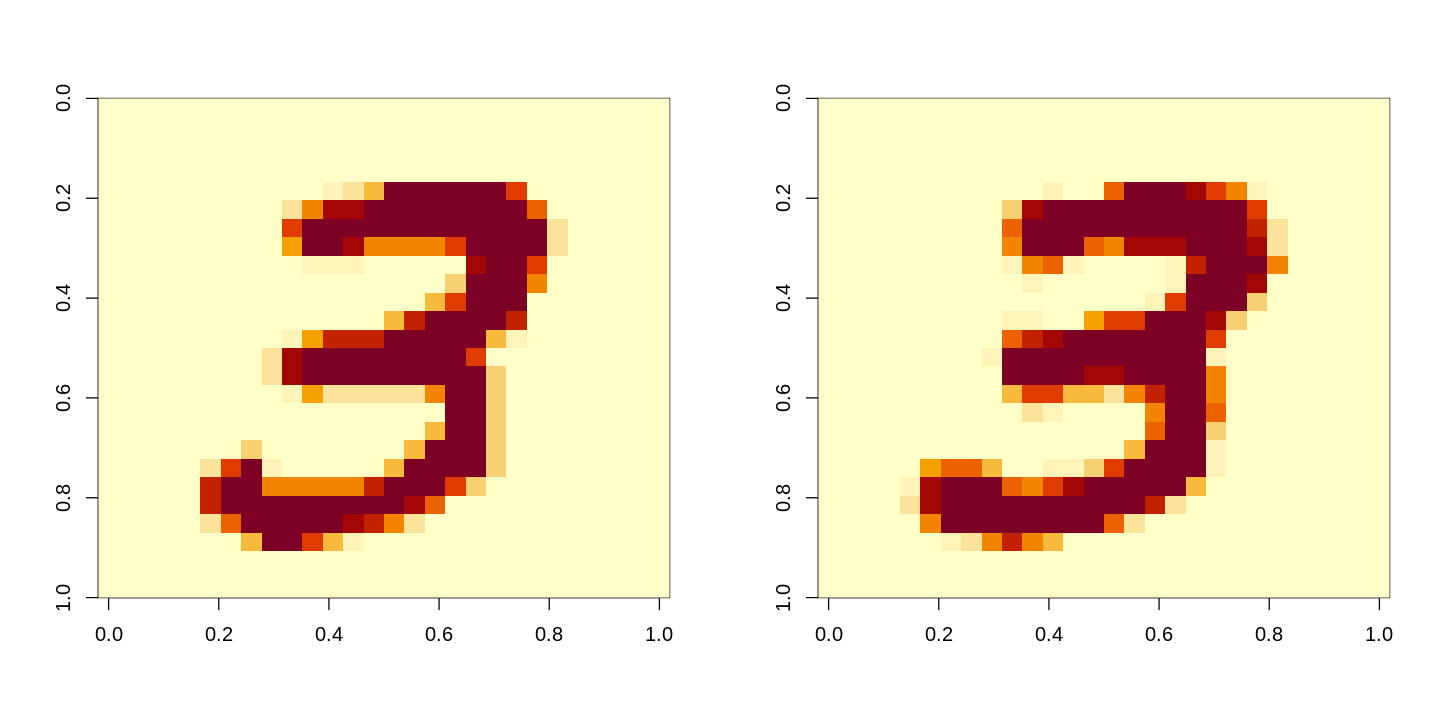

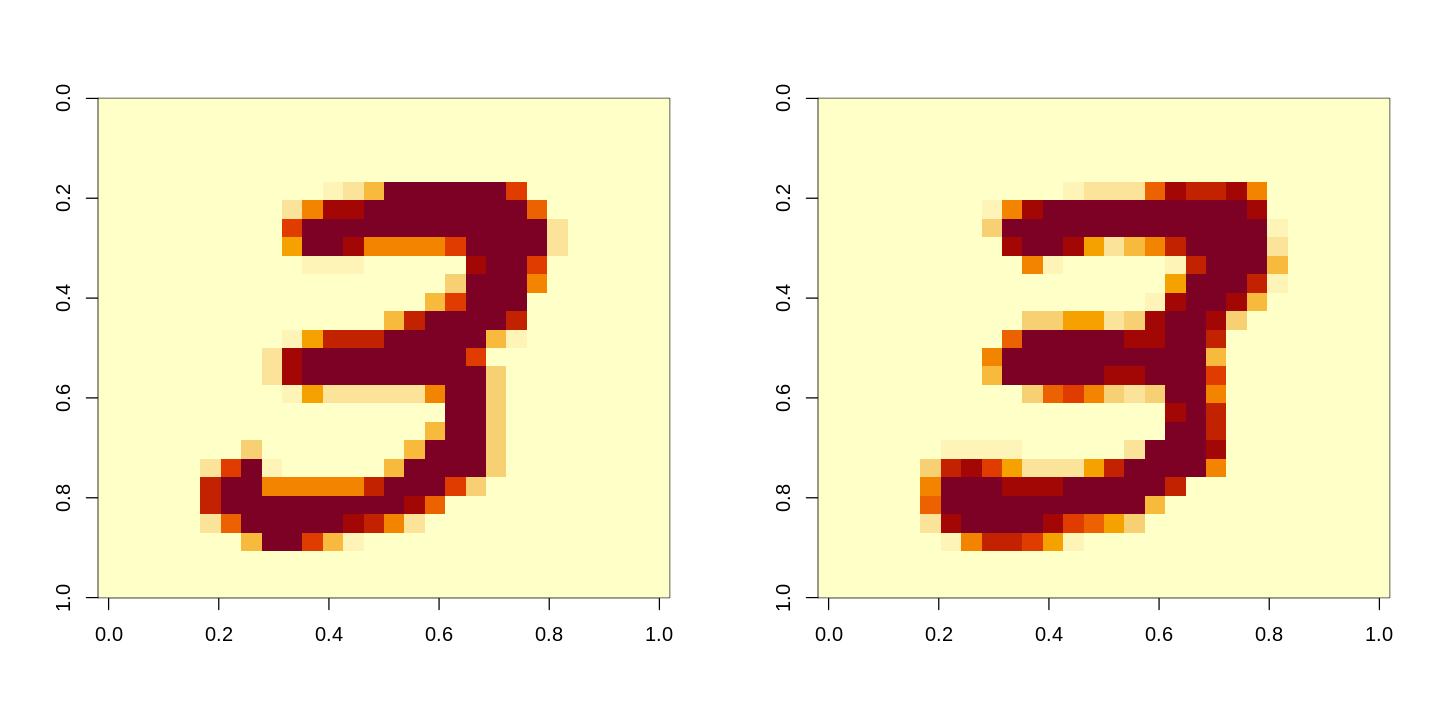

In [ ]:
rbm_gen_adam = RBM_training(x = x_train, y = y_train,
                       n.hidden = 200, 
                       x_val = x_val, y_val = y_val, 
                       type = 'generative',
                       alpha = 0.01, 
                       lr = 0.01,
                       n.epoch = 50,
                       batch.size = 100, 
                       opt = 'Adam', 
                       mu = 0.5, #for Momentum
                       beta1 = 0.9, #for Adam
                       beta2 = 0.999, #for Adam
                       eps = 1e-8, #for Adam
                       sample_rec = 7 #sample observation for inspecting reconstruction during Generative training
)

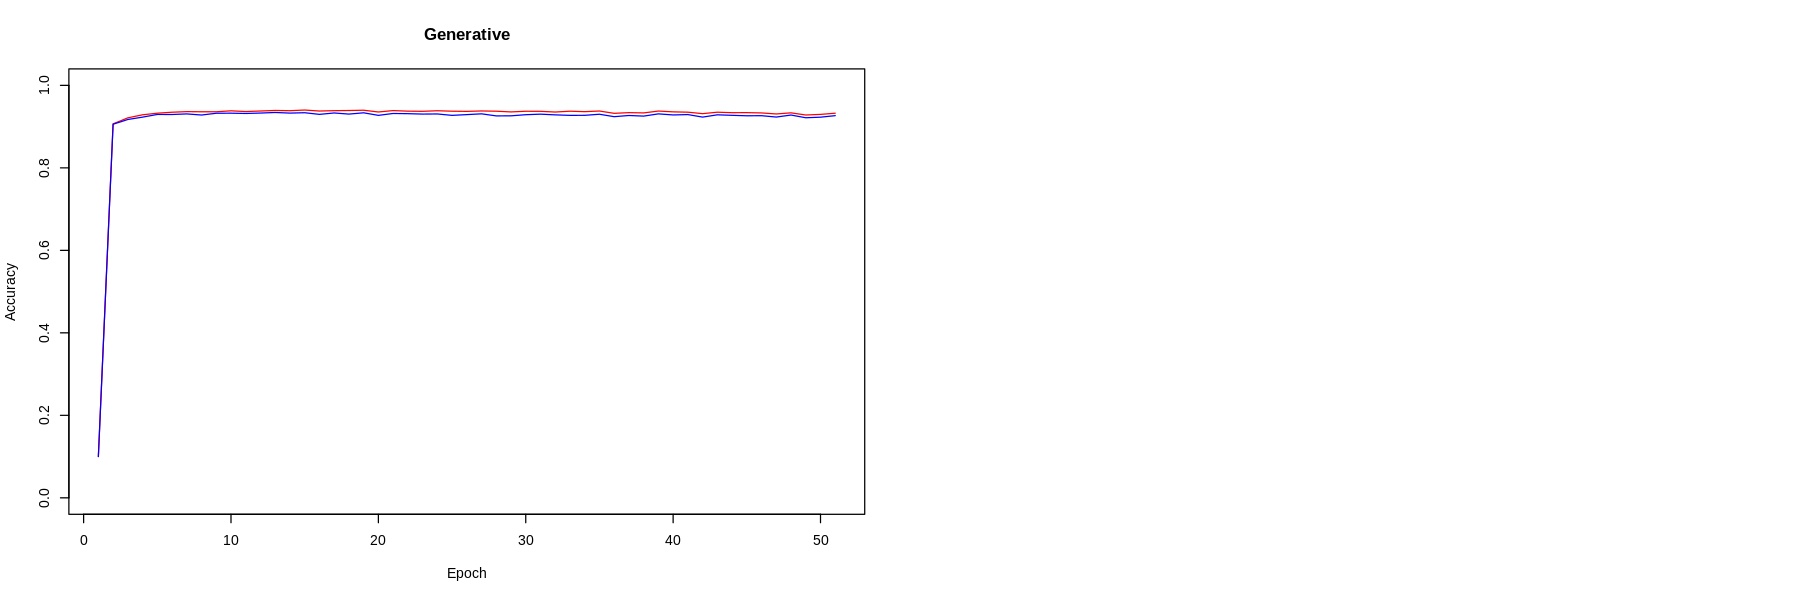

In [ ]:
#windows(10,3)
options(repr.plot.width=15, repr.plot.height=5)
par(mfrow=c(1,2), cex=0.7)
plot(c(0.1,rbm_gen_adam$train_acc), col = 'red', type = 'l', xlab = 'Epoch', ylab = 'Accuracy', ylim = c(0,1), main = 'Generative')
lines(c(0.1,rbm_gen_adam$val_acc), col = 'blue')
legend(80,0.5,legend=c("train","validation"), col=c("red","blue"), lty=c(1,1), cex=0.8)

# **Discriminative**

In [ ]:
rbm_dis = RBM_training(x = x_train, y = y_train,
                       n.hidden = 500, 
                       x_val = x_val, y_val = y_val, 
                       type = 'discriminative',
                       alpha = 0.01, 
                       lr = 0.001,
                       n.epoch = 20,
                       batch.size = 10, 
                       opt = 'Adam', 
                       mu = 0.5, #for Momentum
                       beta1 = 0.9, #for Adam
                       beta2 = 0.999, #for Adam
                       eps = 1e-8, #for Adam
                       sample_rec = 27 #sample observation for inspecting reconstruction during Generative training
)

[1] "Epoch 1"
[1] "Training accuracy: 0.92716"
[1] "Validation accuracy: 0.9242"
[1] "Epoch 2"
[1] "Training accuracy: 0.95146"
[1] "Validation accuracy: 0.9424"
[1] "Epoch 3"
[1] "Training accuracy: 0.95634"
[1] "Validation accuracy: 0.9445"
[1] "Epoch 4"
[1] "Training accuracy: 0.96002"
[1] "Validation accuracy: 0.9489"
[1] "Epoch 5"
[1] "Training accuracy: 0.96392"
[1] "Validation accuracy: 0.9514"
[1] "Epoch 6"
[1] "Training accuracy: 0.97106"
[1] "Validation accuracy: 0.9556"
[1] "Epoch 7"
[1] "Training accuracy: 0.97742"
[1] "Validation accuracy: 0.9612"
[1] "Epoch 8"
[1] "Training accuracy: 0.98058"
[1] "Validation accuracy: 0.9627"
[1] "Epoch 9"
[1] "Training accuracy: 0.98052"
[1] "Validation accuracy: 0.9625"
[1] "Epoch 10"
[1] "Training accuracy: 0.97958"
[1] "Validation accuracy: 0.9614"
[1] "Epoch 11"
[1] "Training accuracy: 0.98042"
[1] "Validation accuracy: 0.9606"
[1] "Epoch 12"
[1] "Training accuracy: 0.98538"
[1] "Validation accuracy: 0.9638"
[1] "Epoch 13"
[1] "Train

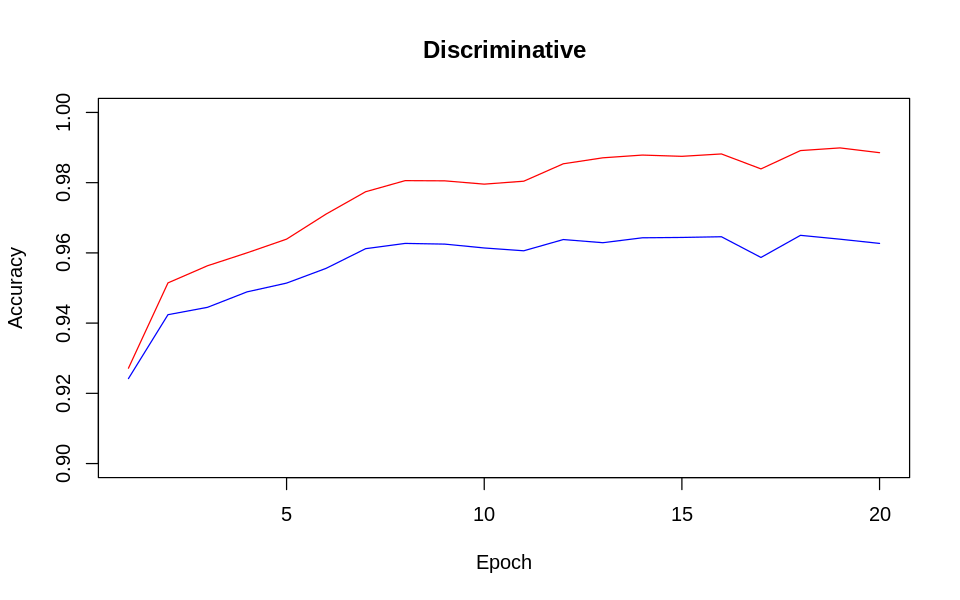

In [ ]:
options(repr.plot.width=8, repr.plot.height=5)
plot(c(rbm_dis$train_acc), col = 'red', type = 'l', xlab = 'Epoch', ylab = 'Accuracy', ylim = c(0.90,1), main = 'Discriminative')
lines(c(rbm_dis$val_acc), col = 'blue')
legend(80,0.98,legend=c("train","validation"), col=c("red","blue"), lty=c(1,1), cex=0.8)

In [ ]:
rbm_dis = RBM_training(x = x_train, y = y_train,
                       n.hidden = 200, 
                       x_val = x_val, y_val = y_val, 
                       type = 'discriminative',
                       alpha = 0.01, 
                       lr = 0.001,
                       n.epoch = 70,
                       batch.size = 100, 
                       opt = 'Adam', 
                       mu = 0.5, #for Momentum
                       beta1 = 0.9, #for Adam
                       beta2 = 0.999, #for Adam
                       eps = 1e-8, #for Adam
                       sample_rec = 27 #sample observation for inspecting reconstruction during Generative training
)

[1] "Epoch 1"
[1] "Training accuracy: 0.92976"
[1] "Validation accuracy: 0.9199"
[1] "Epoch 2"
[1] "Training accuracy: 0.94134"
[1] "Validation accuracy: 0.9308"
[1] "Epoch 3"
[1] "Training accuracy: 0.94838"
[1] "Validation accuracy: 0.9362"
[1] "Epoch 4"
[1] "Training accuracy: 0.95342"
[1] "Validation accuracy: 0.9401"
[1] "Epoch 5"
[1] "Training accuracy: 0.9572"
[1] "Validation accuracy: 0.9432"
[1] "Epoch 6"
[1] "Training accuracy: 0.95952"
[1] "Validation accuracy: 0.9459"
[1] "Epoch 7"
[1] "Training accuracy: 0.96246"
[1] "Validation accuracy: 0.9481"
[1] "Epoch 8"
[1] "Training accuracy: 0.96484"
[1] "Validation accuracy: 0.9488"
[1] "Epoch 9"
[1] "Training accuracy: 0.96706"
[1] "Validation accuracy: 0.9508"
[1] "Epoch 10"
[1] "Training accuracy: 0.96928"
[1] "Validation accuracy: 0.9532"
[1] "Epoch 11"
[1] "Training accuracy: 0.9703"
[1] "Validation accuracy: 0.9533"
[1] "Epoch 12"
[1] "Training accuracy: 0.97266"
[1] "Validation accuracy: 0.9545"
[1] "Epoch 13"
[1] "Trainin

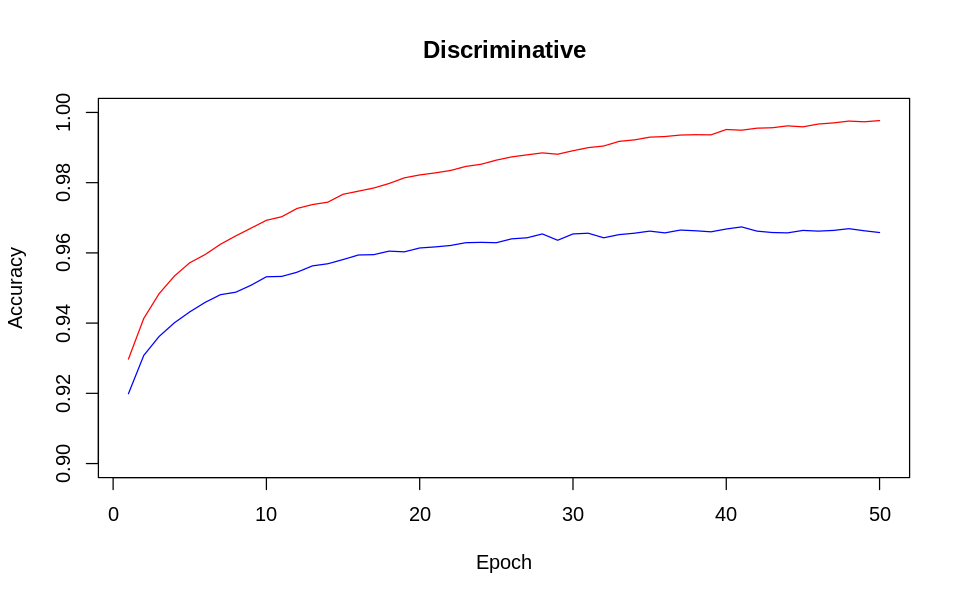

In [ ]:
options(repr.plot.width=8, repr.plot.height=5)
plot(c(rbm_dis$train_acc), col = 'red', type = 'l', xlab = 'Epoch', ylab = 'Accuracy', ylim = c(0.90,1), main = 'Discriminative')
lines(c(rbm_dis$val_acc), col = 'blue')
legend(80,0.98,legend=c("train","validation"), col=c("red","blue"), lty=c(1,1), cex=0.8)

# **Hybrid**

In [ ]:
rbm_hyb = RBM_training(x = x_train, y = y_train, 
                       n.hidden = 200, 
                       x_val = x_val, y_val = y_val, 
                       type = 'hybrid',
                       alpha = 0.01, 
                       lr = 0.001,
                       n.epoch = 100,
                       batch.size = 100, 
                       opt = 'Adam', 
                       mu = 0.9, #for Momentum
                       beta1 = 0.9, #for Adam
                       beta2 = 0.999, #for Adam
                       eps = 1e-8, #for Adam
                       sample_rec = 27#sample observation for inspecting reconstruction during Generative training
)

[1] "Epoch 1"
[1] "Training accuracy: 0.9169"
[1] "Validation accuracy: 0.9089"
[1] "Epoch 2"
[1] "Training accuracy: 0.93814"
[1] "Validation accuracy: 0.9301"
[1] "Epoch 3"
[1] "Training accuracy: 0.9467"
[1] "Validation accuracy: 0.9378"
[1] "Epoch 4"
[1] "Training accuracy: 0.95252"
[1] "Validation accuracy: 0.9434"
[1] "Epoch 5"
[1] "Training accuracy: 0.95744"
[1] "Validation accuracy: 0.9476"
[1] "Epoch 6"
[1] "Training accuracy: 0.96046"
[1] "Validation accuracy: 0.9501"
[1] "Epoch 7"
[1] "Training accuracy: 0.96304"
[1] "Validation accuracy: 0.9502"
[1] "Epoch 8"
[1] "Training accuracy: 0.965"
[1] "Validation accuracy: 0.9522"
[1] "Epoch 9"
[1] "Training accuracy: 0.96764"
[1] "Validation accuracy: 0.9539"
[1] "Epoch 10"
[1] "Training accuracy: 0.96936"
[1] "Validation accuracy: 0.9544"
[1] "Epoch 11"
[1] "Training accuracy: 0.97022"
[1] "Validation accuracy: 0.956"
[1] "Epoch 12"
[1] "Training accuracy: 0.9719"
[1] "Validation accuracy: 0.9559"
[1] "Epoch 13"
[1] "Training ac

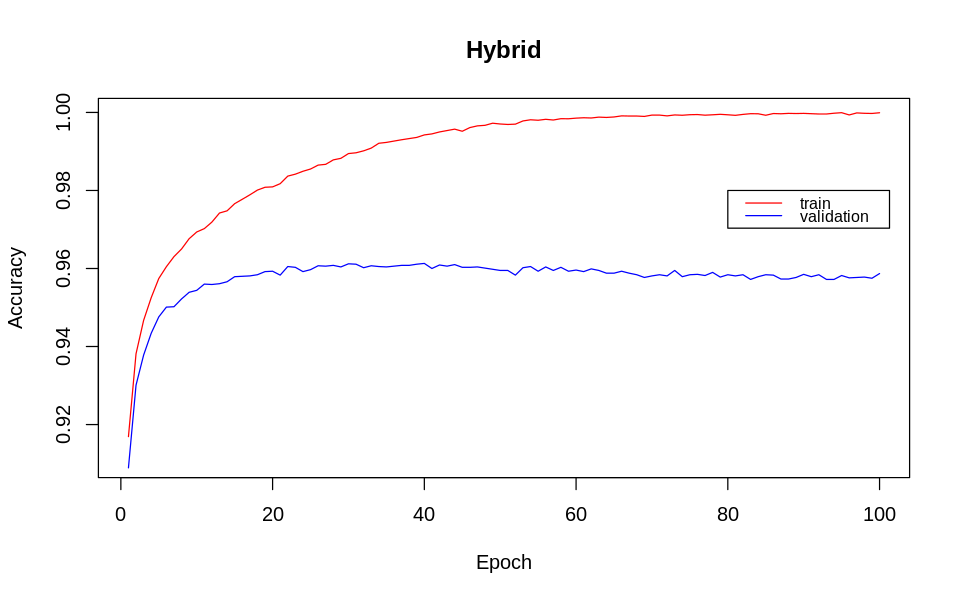

In [ ]:
options(repr.plot.width=8, repr.plot.height=5)
plot(c(rbm_hyb$train_acc), col = 'red', type = 'l', xlab = 'Epoch', ylab = 'Accuracy', ylim = c(0.91,1), main = 'Hybrid')
lines(c(rbm_hyb$val_acc), col = 'blue')
legend(80,0.98,legend=c("train","validation"), col=c("red","blue"), lty=c(1,1), cex=0.8)